# Explore sample-level QC results

In this notebook, we explore sample-level QC results generated by [Sample-Level-QC.Rmd](https://github.com/verilylifesciences/variant-qc/blob/master/R/Sample-Level-QC.Rmd) and examine the outliers.

<div class='alert alert-block alert-info'>
<b>How to use this notebook:</b><p>
    
<a href="https://github.com/verilylifesciences/variant-qc/blob/master/R/Sample-Level-QC.Rmd">RMarkdown</a> was used to run a set of analyses and generate a canned report. If you have questions about the details of the analyses, see the canned reports for details. This notebook reads in those previously computed results, and re-renders 'small multiples' of the results.<p>
    
In this notebook you can:<ul>    
        <li>Use <a href="https://papermill.readthedocs.io/en/latest/usage-parameterize.html">Papermill parameters</a> to select which dataset you'd like to explore. Options include:<ul>
            <li><a href="https://www.simonsfoundation.org/simons-genome-diversity-project/">The Simons Genome Diversity Project</a>
            <li><a href="https://www.internationalgenome.org/category/phase-3/">1000 Geomes Phase 3 Variants</a>
            <li>Deep Variant Platinum Genomes
            </ul>
        <li>Modify the plots
        <li>Add new plots
        <li>Change the QC cutoff thresholds when examining outliers
        <li>Use updated sample information
        <li>Use more features from the sample information
        <li>Choose a custom output filename for the QC problems summary
    </ul><p>
</div>

# Setup 

In [1]:
lapply(c('devtools', 'tidyverse', 'bigrquery', 'scales', 'skimr'),
       function(pkg_name) { if(! pkg_name %in% installed.packages()) { install.packages(pkg_name)} } )

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

[[4]]
NULL

[[5]]
NULL

In [2]:
library(bigrquery)
library(scales)
library(skimr)
library(tidyverse)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ purrr::discard()    masks scales::discard()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()



In [3]:
AUTOSOMES <- c(paste('chr', c(as.character(seq(1, 22))), sep = ''),
               as.character(seq(1, 22)))
ALLOSOMES <- c('chrX', 'X', 'chrY', 'Y')
MITOCHONDRIA <- c('chrM', 'M', 'MT')

In [4]:
DEFAULT_PLOT_HEIGHT <- 7.5
options(repr.plot.width = 16, repr.plot.height = DEFAULT_PLOT_HEIGHT)
theme_set(theme_bw(base_size = 16))
update_geom_defaults('point', list(size = 2))

#' Returns a data frame with a y position and a label, for use annotating ggplot boxplots.
#'
#' @param d A data frame.
#' @return A data frame with column y as max and column label as length.
#'
get_boxplot_fun_data <- function(d) {
  return(data.frame(y = max(d), label = stringr::str_c('N = ', length(d))))
}

In [5]:
# GCS paths and BigQuery queries for datasets
DATASETS <- c('simons', 'thousand_genomes', 'platinum_genomes')

CHROM_RESULTS_PATHS <- list(simons = 'gs://genomics-public-data/simons-genome-diversity-project/reports/Simons_Genome_Diversity_Project_sample_reference_results.csv',
                            platinum_genomes = 'gs://genomics-public-data/platinum-genomes/reports/DeepVariant_Platinum_Genomes_sample_reference_results.csv',
                            thousand_genomes = 'gs://genomics-public-data/1000-genomes-phase-3/reports/1000_Genomes_phase_3_sample_reference_results.csv')

GENOME_RESULTS_PATHS <- list(simons = 'gs://genomics-public-data/simons-genome-diversity-project/reports/Simons_Genome_Diversity_Project_sample_results.csv',
                             platinum_genomes = 'gs://genomics-public-data/platinum-genomes/reports/DeepVariant_Platinum_Genomes_sample_results.csv',
                             thousand_genomes = 'gs://genomics-public-data/1000-genomes-phase-3/reports/1000_Genomes_phase_3_sample_results.csv')

simons_sample_info_query <- '
    SELECT
      id_from_vcf AS name,
      "Illumina" AS sequencing_platform,
      sex,
      region AS ancestry
    FROM
      `bigquery-public-data.human_genome_variants.simons_genome_diversity_project_sample_attributes`
    '

thousand_genomes_sample_info_query <- '
    SELECT
      Sample AS name,
      "Illumina" AS sequencing_platform,
      Gender AS sex,
      Super_Population AS ancestry
    FROM
      `bigquery-public-data.human_genome_variants.1000_genomes_sample_info`
    '

SAMPLE_INFO_QUERIES <- list(simons = simons_sample_info_query,
                        thousand_genomes = thousand_genomes_sample_info_query,
                        platinum_genomes = thousand_genomes_sample_info_query) # Use 1000 genomes for DV platinum

## Papermill Parameters

This next cell contains [Papermill parameters](https://papermill.readthedocs.io/en/latest/usage-parameterize.html). You'll notice it has a `parameters` cell tag. You can set cell tags by using the `View` > `Cell Toolbar` > `Tags` menu option.

Use the `DATASET` parameter to select which dataset you'd like to examine:

* `simons` for the Simons Genome Diversity Project
* `thousand_genomes` for the 1000 Genomes Phase 3 Release
* `platinum_genomes` for the Deep Variant platinum genomes

Use the `CSV_OUTPUT_FILE_NAME` parameter to name your CSV output file. If you leave it unset, it will default to `<DATASET>_problem_summary.csv`.


In [6]:
BILLING_PROJECT_ID <- Sys.getenv('GOOGLE_PROJECT')
DATASET <- 'simons'
CSV_OUTPUT_FILE_NAME <- NULL

### Validate Papermill parameters

In [7]:
if (!(DATASET %in% DATASETS)) {
    stop(str_glue(DATASET, ' is not a valid dataset name. Valid names are: [', 
                  paste(DATASETS, collapse = ', '), ']'))
}

if (is.null(CSV_OUTPUT_FILE_NAME)) {
    CSV_OUTPUT_FILE_NAME <- str_glue(DATASET, '_problem_summary.csv')
}

print(DATASET)
print(CSV_OUTPUT_FILE_NAME)

[1] "simons"
simons_problem_summary.csv


## Retrieve sample information

In [8]:
# Query sample info for `DATASET` from BigQuery
sample_info <- bq_table_download(bq_project_query(BILLING_PROJECT_ID, SAMPLE_INFO_QUERIES[[DATASET]]))

print(skim(sample_info))
dim(sample_info)

── Data Summary ────────────────────────
                           Values     
Name                       sample_info
Number of rows             279        
Number of columns          4          
_______________________               
Column type frequency:                
  character                4          
________________________              
Group variables            None       

── Variable type: character ────────────────────────────────────────────────────
  skim_variable       n_missing complete_rate min max empty n_unique whitespace
1 name                        0         1       9  17     0      279          0
2 sequencing_platform         0         1       8   8     0        1          0
3 sex                        31         0.889   1   6     0        3          0
4 ancestry                    0         1       6  18     0        7          0


,skim_variable,n_missing,complete_rate,min,max,empty,n_unique,whitespace
,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>
1,name,0,1.0000000,9,17,0,279,0
2,sequencing_platform,0,1.0000000,8,8,0,1,0
3,sex,31,0.8888889,1,6,0,3,0
4,ancestry,0,1.0000000,6,18,0,7,0


[1] 279   4

## Retrieve previously computed results

In [9]:
genome_results <- read_csv(pipe(str_glue('gsutil cat ', GENOME_RESULTS_PATHS[[DATASET]])))
genome_results <- genome_results[,!grepl('X1', colnames(genome_results))]  # Drop row name column, if present.

print(skim(genome_results))

New names:
• `` -> `...1`
Rows: 279 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): name
dbl (10): ...1, no_calls, all_calls, missingness_rate, private_variant_count...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


── Data Summary ────────────────────────
                           Values        
Name                       genome_results
Number of rows             279           
Number of columns          11            
_______________________                  
Column type frequency:                   
  character                1             
  numeric                  10            
________________________                 
Group variables            None          

── Variable type: character ────────────────────────────────────────────────────
  skim_variable n_missing complete_rate min max empty n_unique whitespace
1 name                  0             1   9  17     0      279          0

── Variable type: numeric ──────────────────────────────────────────────────────
   skim_variable              n_missing complete_rate        mean          sd
 1 ...1                               0         1         140         80.7   
 2 no_calls                           0         1      566697.     7868

$character

── Variable type: character ────────────────────────────────────────────────────
  skim_variable n_missing complete_rate min max empty n_unique whitespace
1 name                  0             1   9  17     0      279          0

$numeric

── Variable type: numeric ──────────────────────────────────────────────────────
   skim_variable n_missing complete_rate    mean      sd      p0     p25     p50
 1 ...1                  0         1     1.4 e+2 8.07e+1 1   e+0 7.05e+1 1.4 e+2
 2 no_calls              0         1     5.67e+5 7.87e+4 0       5.27e+5 5.53e+5
 3 all_calls             0         1     4.20e+6 3.48e+5 3.73e+6 4.05e+6 4.09e+6
 4 missingness_…         0         1     1.35e-1 1.54e-2 0       1.29e-1 1.35e-1
 5 private_vari…         2         0.993 5.17e+4 3.99e+4 1.56e+4 3.20e+4 3.84e+4
 6 heterozygous…         2         0.993 1.54e+6 2.41e+5 1.06e+6 1.40e+6 1.52e+6
 7 perct_het_al…         2         0.993 2.14e-1 2.72e-1 6   e-3 9   e-3 1.2 e-2
 8 perct_hom_al…         2         0.993 7.86e-1 2.72e-1 3.12e-1 4.58e-1 9.88e-1
 9 hom_AA_count          2         0.993 4.49e+4 1.51e+4 8.69e+2 3.25e+4 4.93e+4
10 het_RA_count          2         0.993 1.56e+4 2.09e+4 1.9 e+1 4.42e+2 6.5 e+2
# … with 3 more variables: p75 <dbl>, p100 <dbl>, hist <chr>

In [10]:
chrom_results <- read_csv(pipe(str_glue('gsutil cat ', CHROM_RESULTS_PATHS[[DATASET]])))
chrom_results <- chrom_results[,!grepl('X1', colnames(chrom_results))]  # Drop row name column, if present.

print(skim(chrom_results))

New names:
• `` -> `...1`
Rows: 6814 Columns: 11
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): name, reference_name
dbl (9): ...1, number_of_calls, HOM_ALT, HAS_ALT, N_SITES, F, transitions, t...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


── Data Summary ────────────────────────
                           Values       
Name                       chrom_results
Number of rows             6814         
Number of columns          11           
_______________________                 
Column type frequency:                  
  character                2            
  numeric                  9            
________________________                
Group variables            None         

── Variable type: character ────────────────────────────────────────────────────
  skim_variable  n_missing complete_rate min max empty n_unique whitespace
1 name                   0             1   9  17     0      277          0
2 reference_name         0             1   1   2     0       25          0

── Variable type: numeric ──────────────────────────────────────────────────────
  skim_variable   n_missing complete_rate       mean        sd    p0       p25
1 ...1                    0         1       3408.     1967.    1      1704.   
2 

$character

── Variable type: character ────────────────────────────────────────────────────
  skim_variable  n_missing complete_rate min max empty n_unique whitespace
1 name                   0             1   9  17     0      277          0
2 reference_name         0             1   1   2     0       25          0

$numeric

── Variable type: numeric ──────────────────────────────────────────────────────
  skim_variable   n_missing complete_rate     mean      sd    p0     p25     p50
1 ...1                    0         1      3.41e+3 1.97e+3 1     1.70e+3 3.41e+3
2 number_of_calls         0         1      1.07e+5 6.19e+4 9     5.77e+4 1.03e+5
3 HOM_ALT                 0         1      4.43e+4 2.54e+4 7     2.48e+4 4.53e+4
4 HAS_ALT                 0         1      1.07e+5 6.19e+4 9     5.77e+4 1.03e+5
5 N_SITES                 0         1      1.07e+5 6.19e+4 9     5.77e+4 1.03e+5
6 F                       0         1      4.57e-1 1.64e-1 0.297 3.74e-1 4.06e-1
7 transitions            51         0.993  7.32e+4 4.16e+4 8     4.12e+4 7.00e+4
8 transversions          51         0.993  3.44e+4 1.98e+4 1     1.76e+4 3.36e+4
9 titv                   51         0.993  2.78e+0 4.12e+0 1.04  2.08e+0 2.14e+0
# … with 3 more variables: p75 <dbl>, p100 <dbl>, hist <chr>

In [11]:
joined_genome_results <- inner_join(genome_results, sample_info)

dim(joined_genome_results)

Joining, by = "name"


[1] 279  14

In [12]:
joined_chrom_results <- inner_join(chrom_results, sample_info)

dim(joined_chrom_results)

Joining, by = "name"


[1] 6814   14

# Sample information 

`summarise()` has grouped output by 'ancestry'. You can override using the
`.groups` argument.


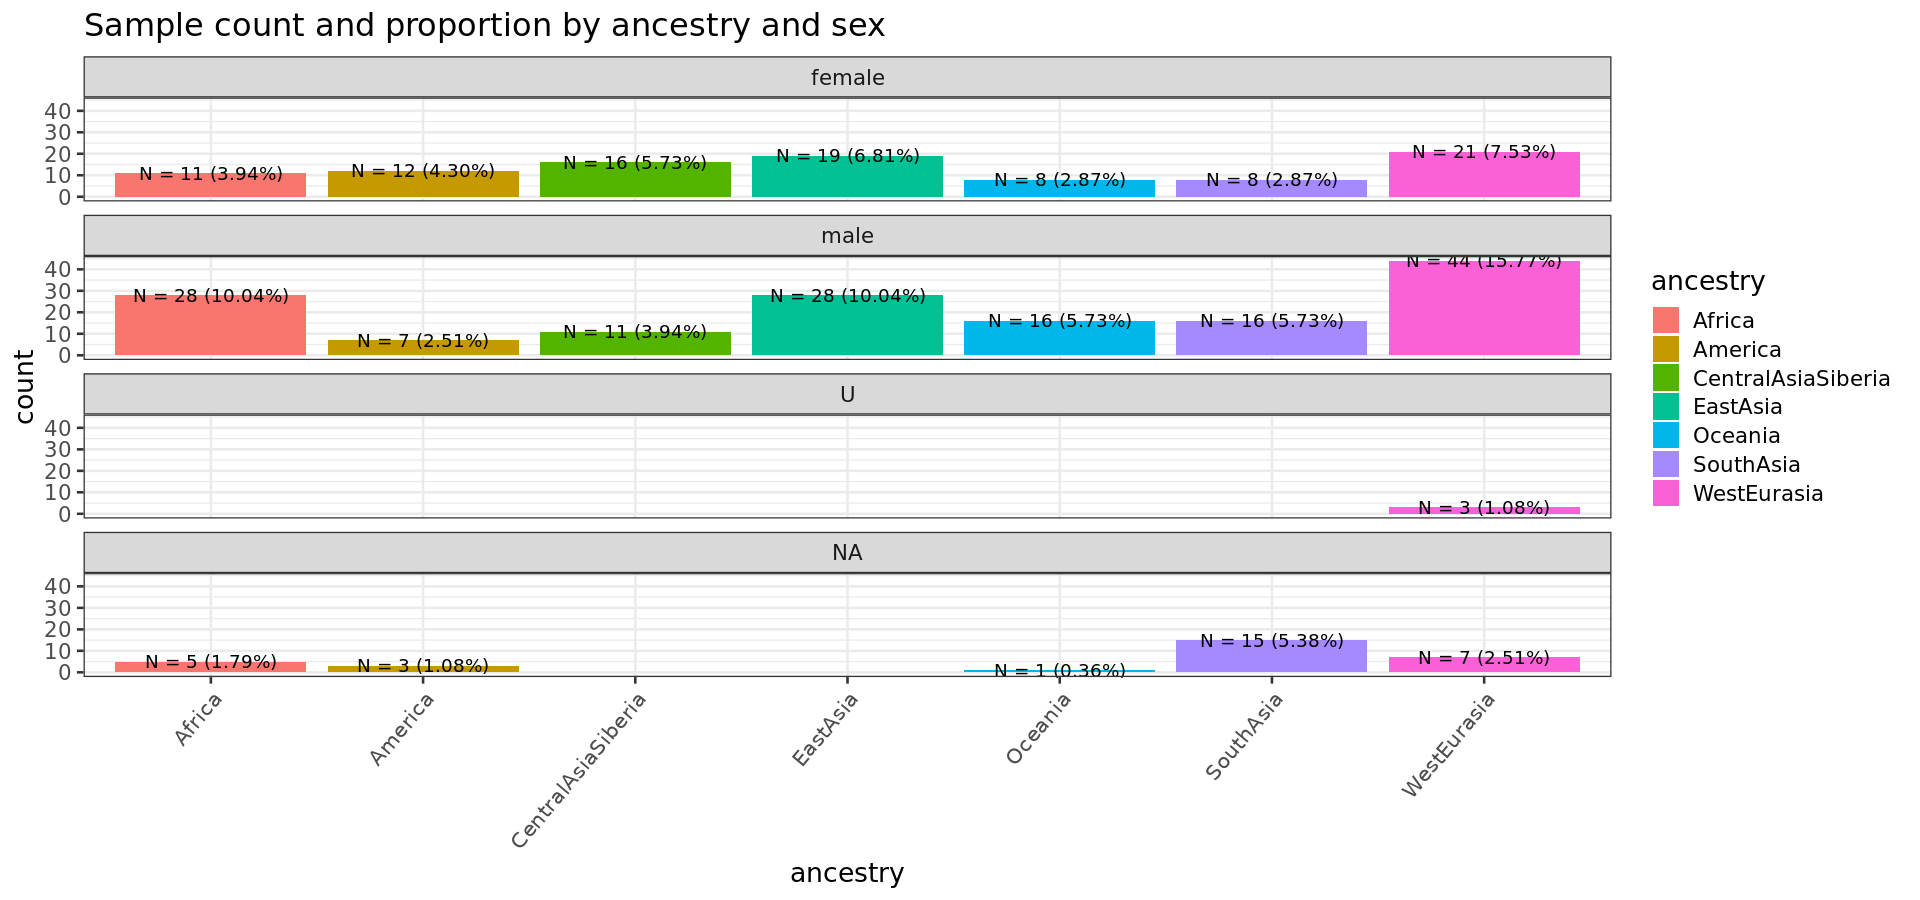

In [13]:
sample_info %>%
  group_by(ancestry, sex) %>%
  summarize(
    count = n(),
    proportion = n() / nrow(.)
  ) %>%
ggplot(aes(x = ancestry, y = count, fill = ancestry)) +
  geom_bar(stat = 'identity', position = 'dodge') +
  geom_text(aes(label = str_glue('N = {count} ({percent(proportion)})'))) +
  facet_wrap( ~ sex, ncol = 1) +
  theme(axis.text.x = element_text(angle = 50, hjust = 1)) +
  ggtitle('Sample count and proportion by ancestry and sex')

`summarise()` has grouped output by 'sequencing_platform'. You can override
using the `.groups` argument.


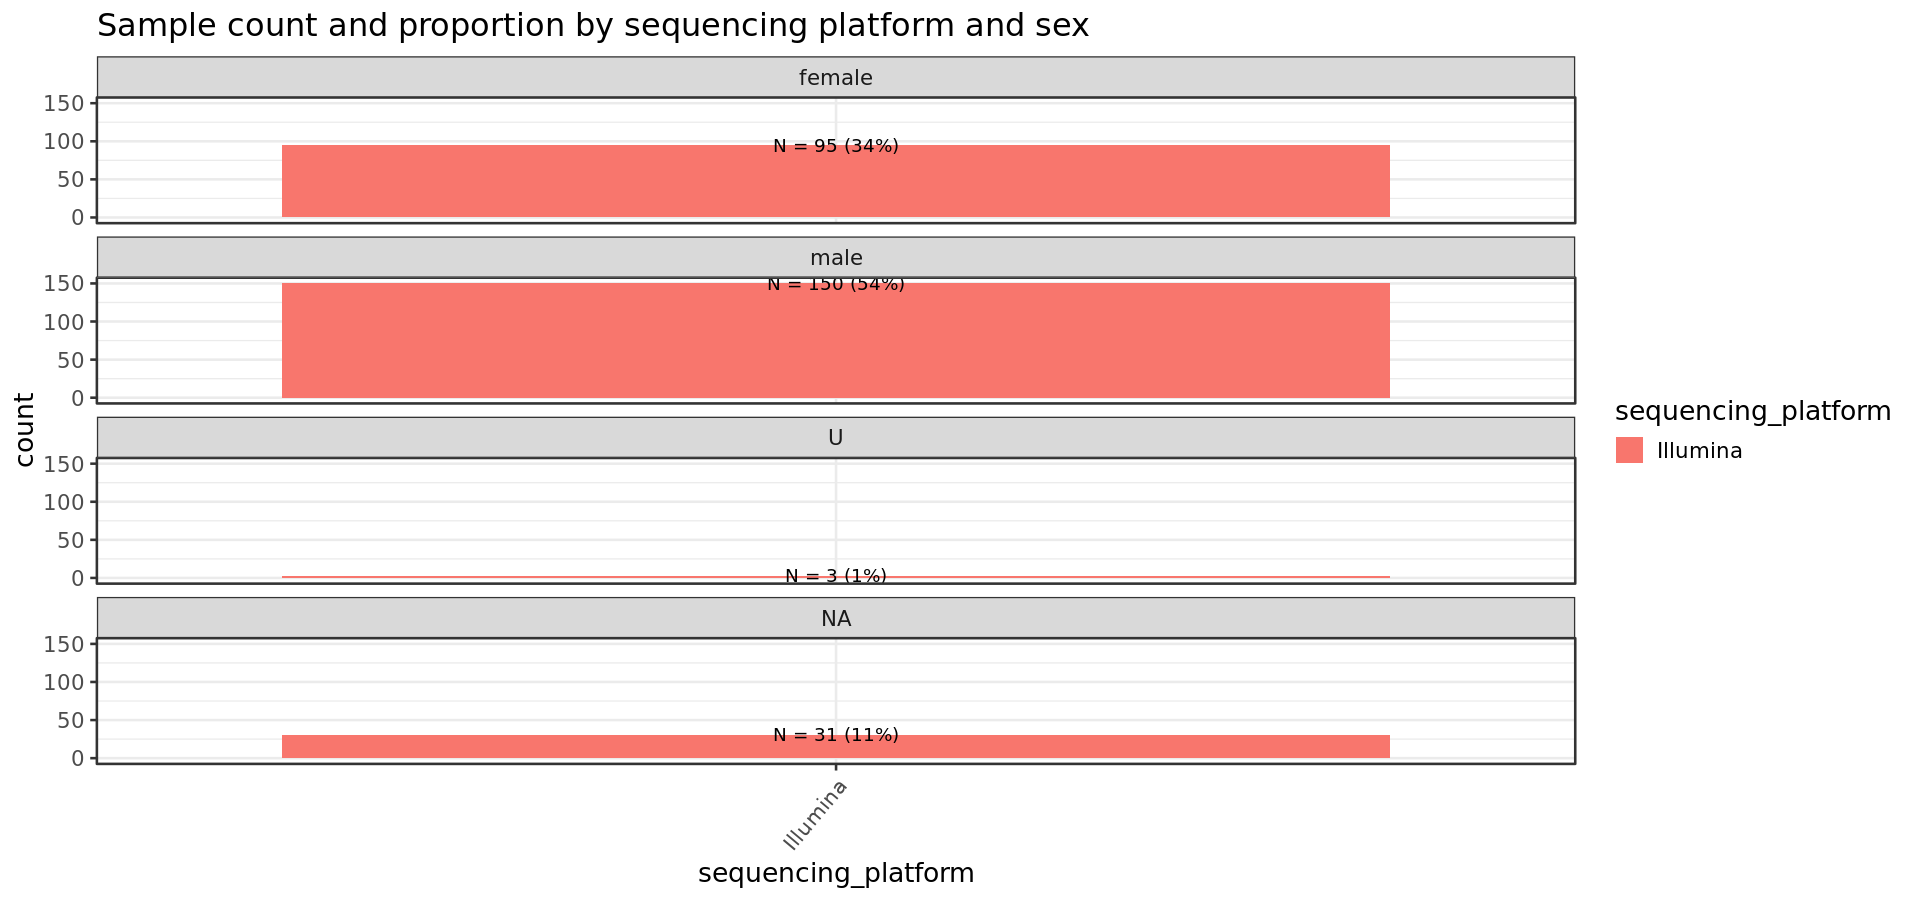

In [14]:
sample_info %>%
  group_by(sequencing_platform, sex) %>%
  summarize(
    count = n(),
    proportion = n() / nrow(.)
  ) %>%
ggplot(aes(x = sequencing_platform, y = count, fill = sequencing_platform)) +
  geom_bar(stat = 'identity', position = 'dodge') +
  geom_text(aes(label = str_glue('N = {count} ({percent(proportion)})'))) +
  coord_cartesian(clip = 'off') +
  facet_wrap(. ~ sex, ncol = 1) +
  theme(axis.text.x = element_text(angle = 50, hjust = 1)) +
  ggtitle('Sample count and proportion by sequencing platform and sex')

# Variant call rate

## Per-chromosome variant call rate

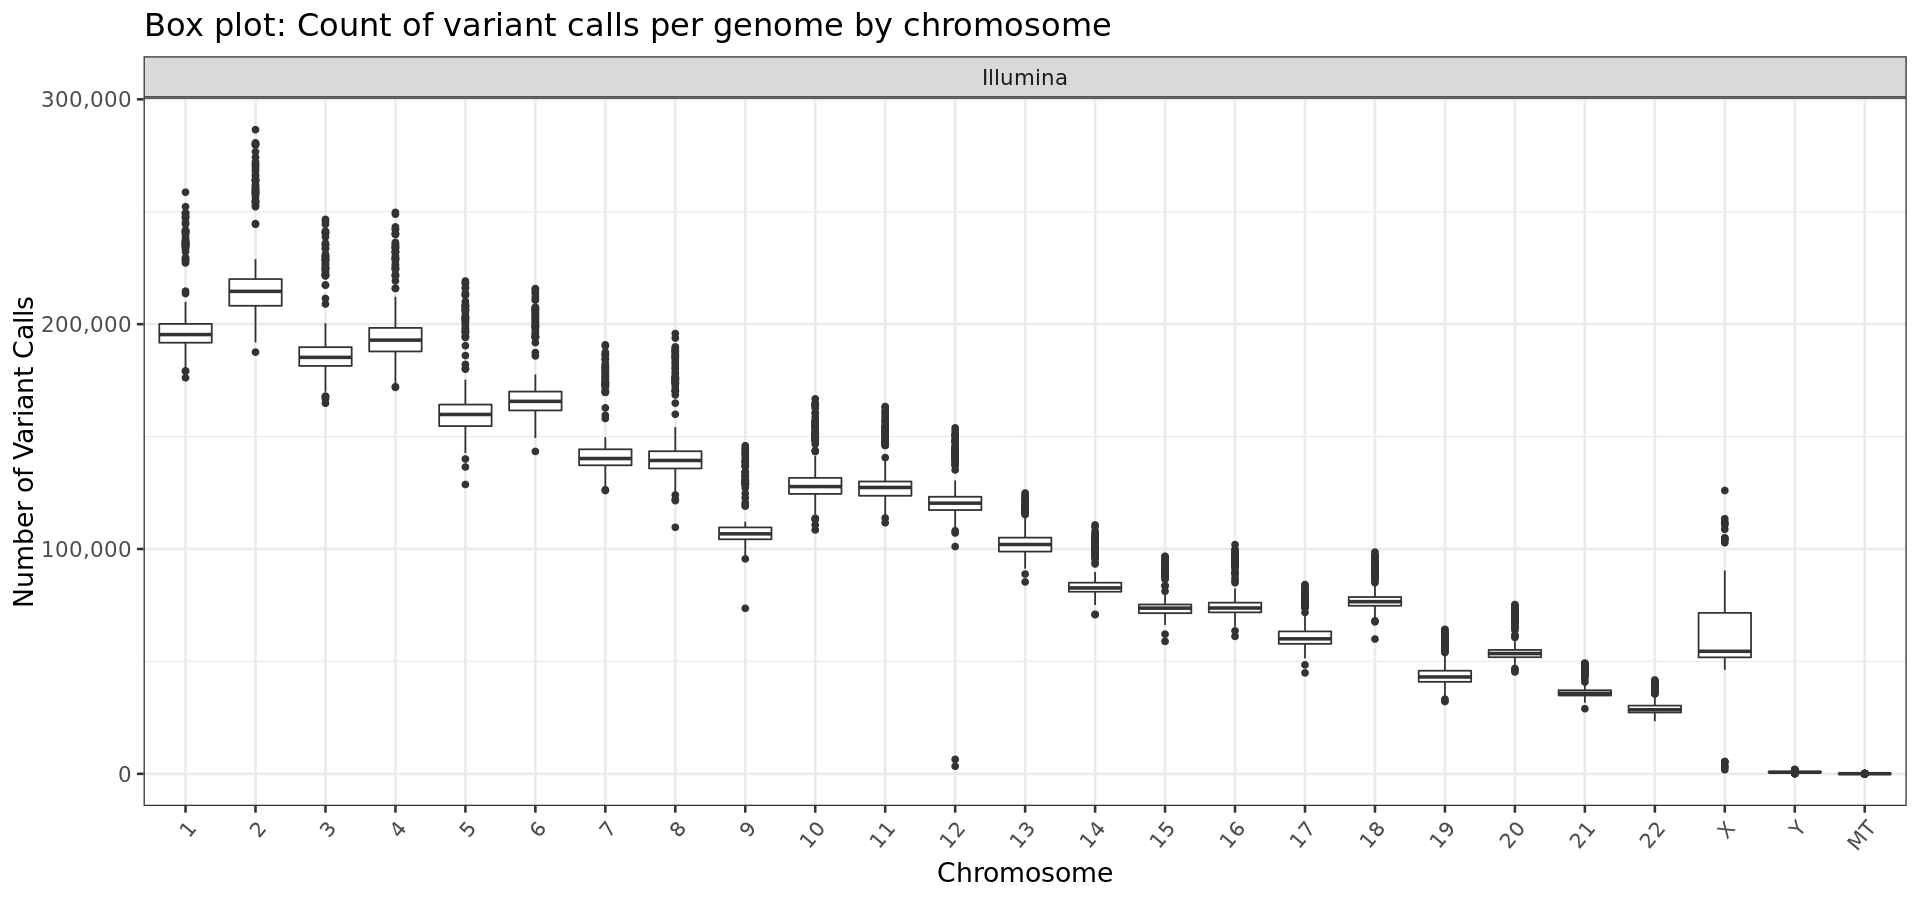

In [15]:
joined_chrom_results %>%
  filter(reference_name %in% c(AUTOSOMES, ALLOSOMES, MITOCHONDRIA)) %>%
  mutate(reference_name = parse_factor(reference_name, levels = c(AUTOSOMES, ALLOSOMES, MITOCHONDRIA))) %>%
ggplot(aes(y = number_of_calls, x = reference_name)) +
  geom_boxplot() +
  scale_y_continuous(labels = comma) +
  facet_wrap(. ~ sequencing_platform, ncol = 1, scales = 'free_y') +
  ylab('Number of Variant Calls') +
  xlab('Chromosome') +
  ggtitle('Box plot: Count of variant calls per genome by chromosome') +
  theme(axis.text.x = element_text(angle = 50, hjust = 1))

## Display per-chromosome outliers 

Compute per chromosome mean and sd call count

In [16]:
chrom_calls_summary <- joined_chrom_results %>%
    group_by(reference_name, sequencing_platform) %>%
    summarize(
        number_of_calls_mean = mean(number_of_calls),
        number_of_calls_sd = sd(number_of_calls),
    )

head(chrom_calls_summary)

`summarise()` has grouped output by 'reference_name'. You can override using
the `.groups` argument.


reference_name,sequencing_platform,number_of_calls_mean,number_of_calls_sd
<chr>,<chr>,<dbl>,<dbl>
1,Illumina,200422.60,16661.118
10,Illumina,130481.60,10789.056
11,Illumina,129456.79,10403.734
12,Illumina,121714.31,13744.301
13,Illumina,103062.03,6769.014
14,Illumina,84736.74,7430.972


In [17]:
low_chrom_calls_sd_multiplier <- 3

(chrom_calls_outliers <- joined_chrom_results %>%
    inner_join(chrom_calls_summary) %>%
    filter(number_of_calls < number_of_calls_mean - (low_chrom_calls_sd_multiplier * number_of_calls_sd)) %>%
    arrange(reference_name, number_of_calls))


Joining, by = c("reference_name", "sequencing_platform")


...1,name,reference_name,number_of_calls,HOM_ALT,HAS_ALT,N_SITES,F,transitions,transversions,titv,sequencing_platform,sex,ancestry,number_of_calls_mean,number_of_calls_sd
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
274,LP6005441-DNA_B03,12,3369,1837,3369,3369,0.54527,2297,1072,2.142724,Illumina,female,Oceania,121714.31,13744.30
4619,LP6005443-DNA_G01,12,6440,3386,6440,6440,0.52578,4511,1929,2.338517,Illumina,female,EastAsia,121714.31,13744.30
6588,SS6004471,9,73619,26039,73619,73619,0.35370,48294,25325,1.906969,Illumina,male,Africa,109534.75,10566.19
1715,LP6005441-DNA_G09,X,1826,1743,1826,1826,0.95455,1232,594,2.074074,Illumina,NA,WestEurasia,61613.38,16510.37
3800,LP6005443-DNA_C01,X,3101,1613,3101,3101,0.52015,2125,976,2.177254,Illumina,male,EastAsia,61613.38,16510.37
5630,LP6005592-DNA_A02,X,3393,1852,3393,3393,0.54583,2310,1083,2.132964,Illumina,male,WestEurasia,61613.38,16510.37
2499,LP6005442-DNA_C10,X,5141,3438,5141,5141,0.66874,3477,1664,2.089543,Illumina,male,WestEurasia,61613.38,16510.37
4515,LP6005443-DNA_F04,X,5431,4149,5431,5431,0.76395,3700,1731,2.137493,Illumina,male,CentralAsiaSiberia,61613.38,16510.37
4294,LP6005443-DNA_E06,X,5450,3471,5450,5450,0.63688,3626,1824,1.987939,Illumina,male,Africa,61613.38,16510.37


In [18]:
problems <- chrom_calls_outliers %>%
                 group_by(name) %>%
                 summarize(
                     fail = str_glue('per chrom variant count is at least {low_chrom_calls_sd_multiplier}',
                                     ' standard deviations below the platform mean for ',
                                     str_c(reference_name, collapse = ',')))

dim(problems)
head(problems)

[1] 9 2

name,fail
<chr>,<glue>
LP6005441-DNA_B03,per chrom variant count is at least 3 standard deviations below the platform mean for 12
LP6005441-DNA_G09,per chrom variant count is at least 3 standard deviations below the platform mean for X
LP6005442-DNA_C10,per chrom variant count is at least 3 standard deviations below the platform mean for X
LP6005443-DNA_C01,per chrom variant count is at least 3 standard deviations below the platform mean for X
LP6005443-DNA_E06,per chrom variant count is at least 3 standard deviations below the platform mean for X
LP6005443-DNA_F04,per chrom variant count is at least 3 standard deviations below the platform mean for X


## Per-genome variant call rate

`summarise()` has grouped output by 'name', 'sex'. You can override using the
`.groups` argument.
Warning message:
“Removed 31 rows containing missing values (geom_point).”


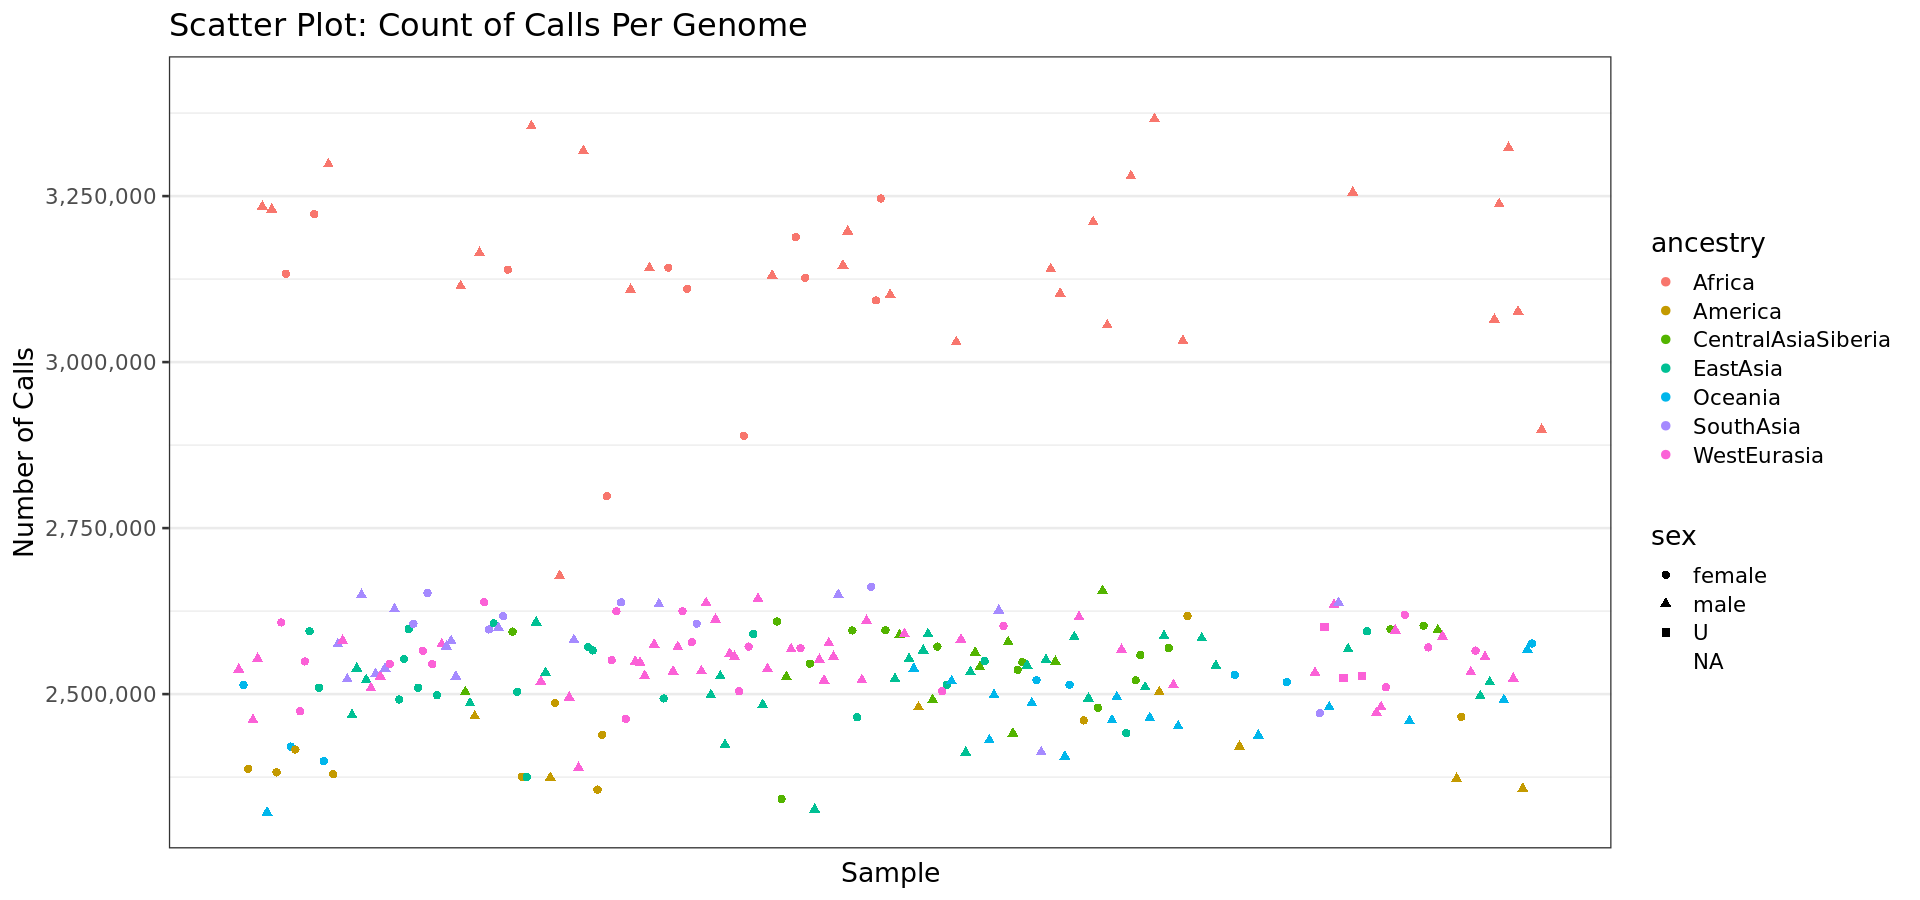

In [19]:
genome_call_rate_summary <- joined_chrom_results %>%
  group_by(name, sex, ancestry) %>%
  summarize(n = sum(number_of_calls))

p <- genome_call_rate_summary %>%
  ggplot() +
  geom_point(aes(x = name, y = n, color = ancestry, shape = sex)) +
  scale_x_discrete(expand = c(0.05, 1)) +
  scale_y_continuous(labels = comma) +
  xlab('Sample') +
  ylab('Number of Calls') +
  ggtitle('Scatter Plot: Count of Calls Per Genome') +
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(),
            panel.grid.major.x = element_blank())
if (nrow(genome_call_rate_summary) <= 20) {
  p + theme(axis.text.x = element_text(angle = 50, hjust = 1))
} else {
  p + theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(),
            panel.grid.major.x = element_blank())
}

`summarise()` has grouped output by 'name', 'sex'. You can override using the
`.groups` argument.
Warning message:
“Removed 31 rows containing missing values (geom_point).”


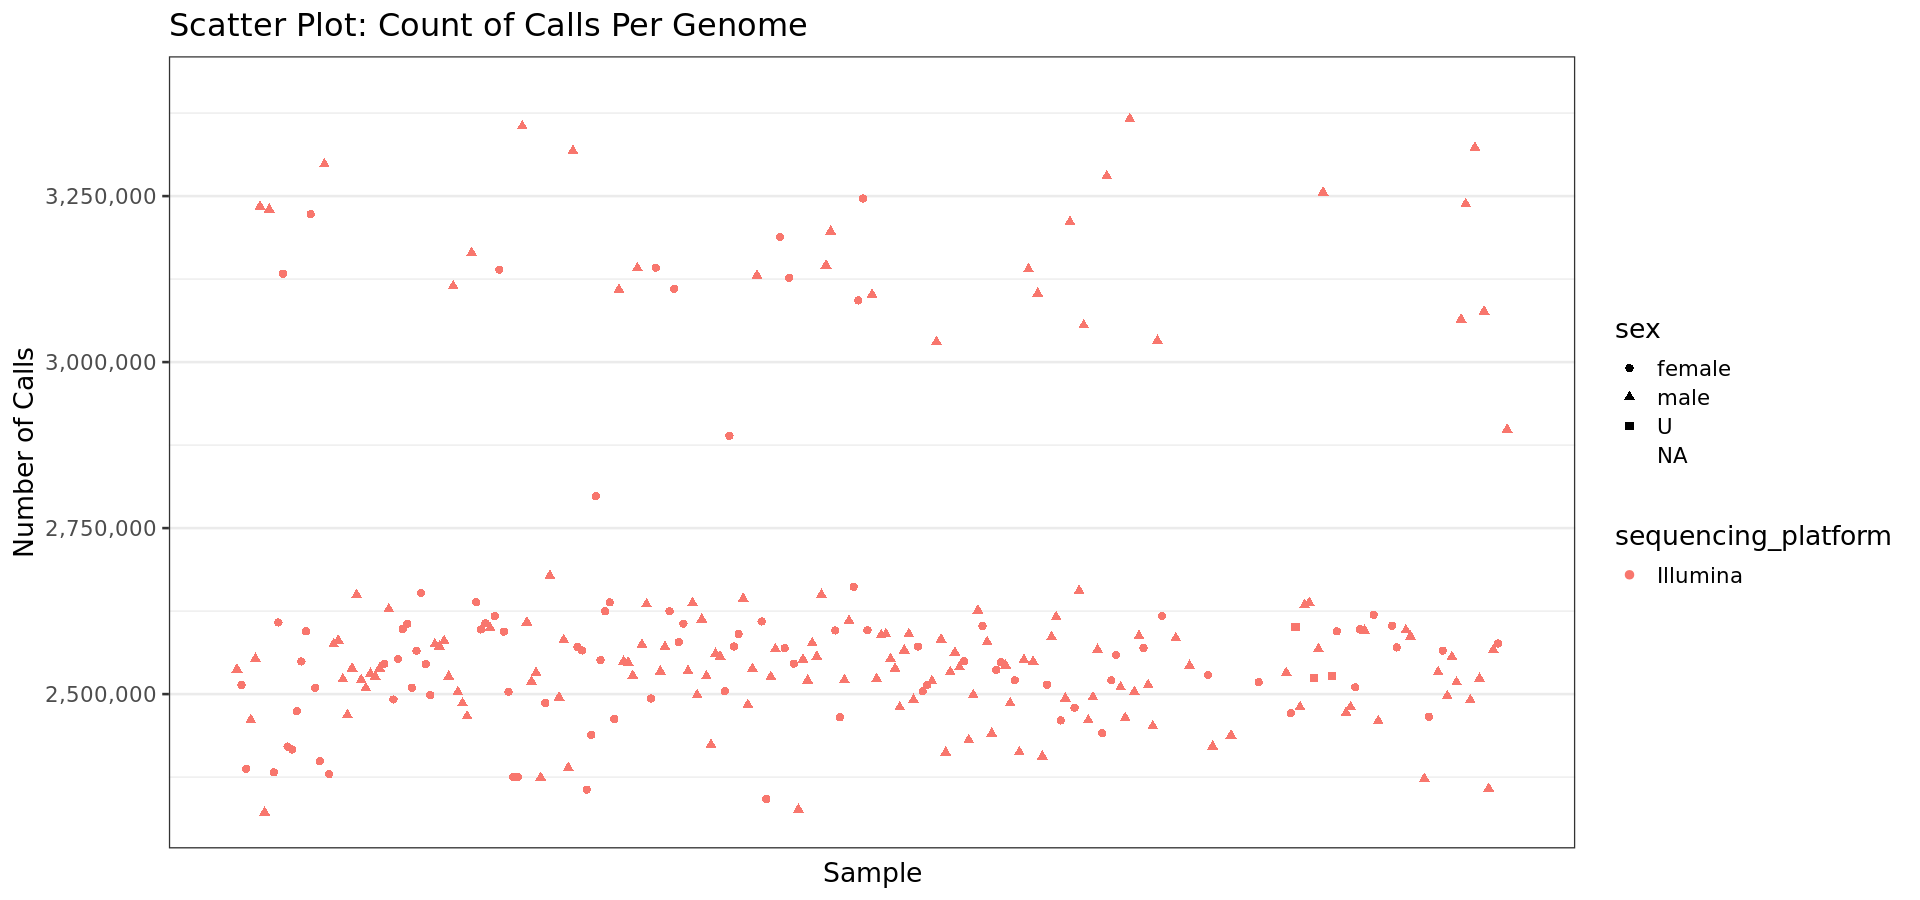

In [20]:
genome_call_rate_summary <- joined_chrom_results %>%
  group_by(name, sex, sequencing_platform) %>%
  summarize(n = sum(number_of_calls))

p <- genome_call_rate_summary %>%
  ggplot() +
  geom_point(aes(x = name, y = n, color = sequencing_platform, shape = sex)) +
  scale_x_discrete(expand = c(0.05, 1)) +
  scale_y_continuous(labels = comma) +
  xlab('Sample') +
  ylab('Number of Calls') +
  ggtitle('Scatter Plot: Count of Calls Per Genome') +
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(),
            panel.grid.major.x = element_blank())
if (nrow(genome_call_rate_summary) <= 20) {
  p + theme(axis.text.x = element_text(angle = 50, hjust = 1))
} else {
  p + theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(),
            panel.grid.major.x = element_blank())
}

## Display per-genome outliers 

In [21]:
genome_calls_summary <- genome_call_rate_summary %>%
    group_by(sequencing_platform) %>%
    summarize(
        genome_calls_mean = mean(n),
        genome_calls_sd = sd(n),
    )

head(genome_calls_summary)

sequencing_platform,genome_calls_mean,genome_calls_sd
<chr>,<dbl>,<dbl>
Illumina,2628486,237032.8


In [22]:
low_genome_calls_sd_multiplier <- 3

(genome_calls_outliers <- genome_call_rate_summary %>%
    inner_join(genome_calls_summary) %>%
    filter(n < genome_calls_mean - (low_genome_calls_sd_multiplier * genome_calls_sd)) %>%
    arrange(n))

Joining, by = "sequencing_platform"


name,sex,sequencing_platform,n,genome_calls_mean,genome_calls_sd
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>


In [23]:
problems <- rbind(
    tibble(name = unique(genome_calls_outliers$name),
           fail = str_glue('per genome variant count is at least {low_genome_calls_sd_multiplier}',
                           ' standard deviations below the platform mean')),
    problems)

dim(problems)
head(problems)

[1] 9 2

name,fail
<chr>,<glue>
LP6005441-DNA_B03,per chrom variant count is at least 3 standard deviations below the platform mean for 12
LP6005441-DNA_G09,per chrom variant count is at least 3 standard deviations below the platform mean for X
LP6005442-DNA_C10,per chrom variant count is at least 3 standard deviations below the platform mean for X
LP6005443-DNA_C01,per chrom variant count is at least 3 standard deviations below the platform mean for X
LP6005443-DNA_E06,per chrom variant count is at least 3 standard deviations below the platform mean for X
LP6005443-DNA_F04,per chrom variant count is at least 3 standard deviations below the platform mean for X


# Missingness rate

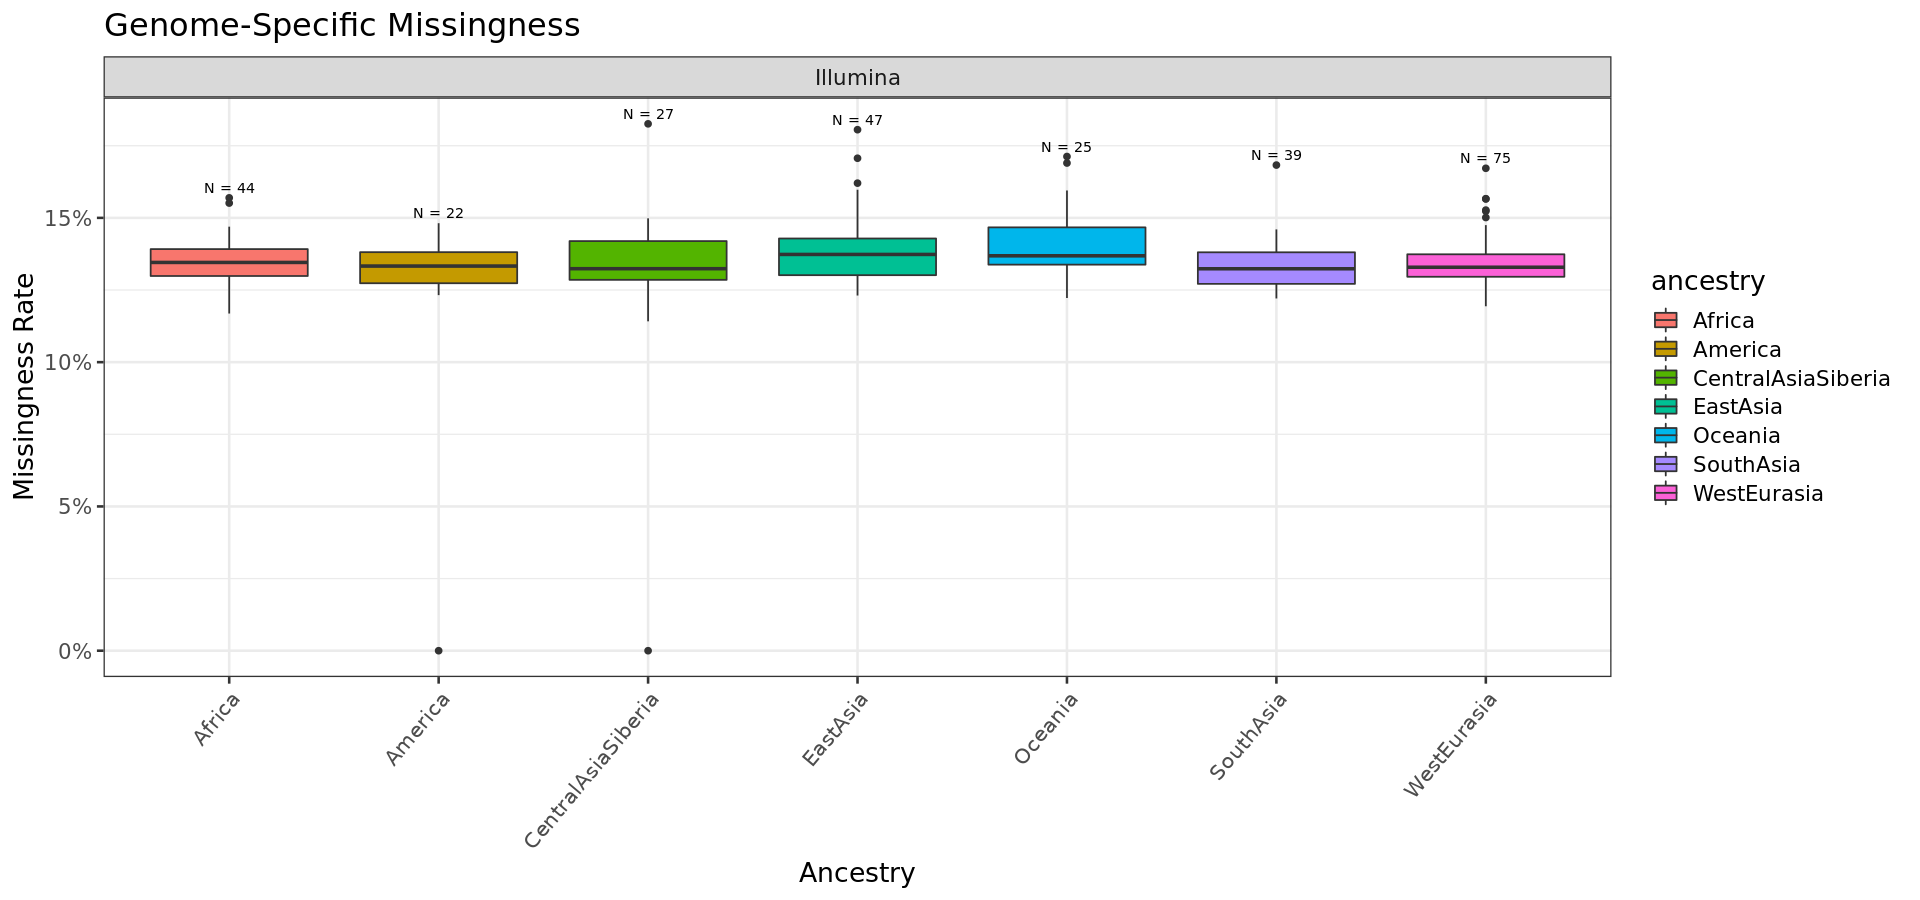

In [24]:
joined_genome_results %>%
ggplot(aes(y = missingness_rate, x = ancestry, fill = ancestry)) +
  geom_boxplot() +
  stat_summary(fun.data = get_boxplot_fun_data, geom = 'text', size = 3,
               position = position_dodge(width = 0.9), vjust = -0.5) +
  scale_y_continuous(labels = percent_format()) +
  facet_wrap(. ~ sequencing_platform, ncol = 1, scales = 'free_y') +
  ylab('Missingness Rate') +
  xlab('Ancestry') +
  ggtitle('Genome-Specific Missingness') +
  theme(axis.text.x = element_text(angle = 50, hjust = 1))

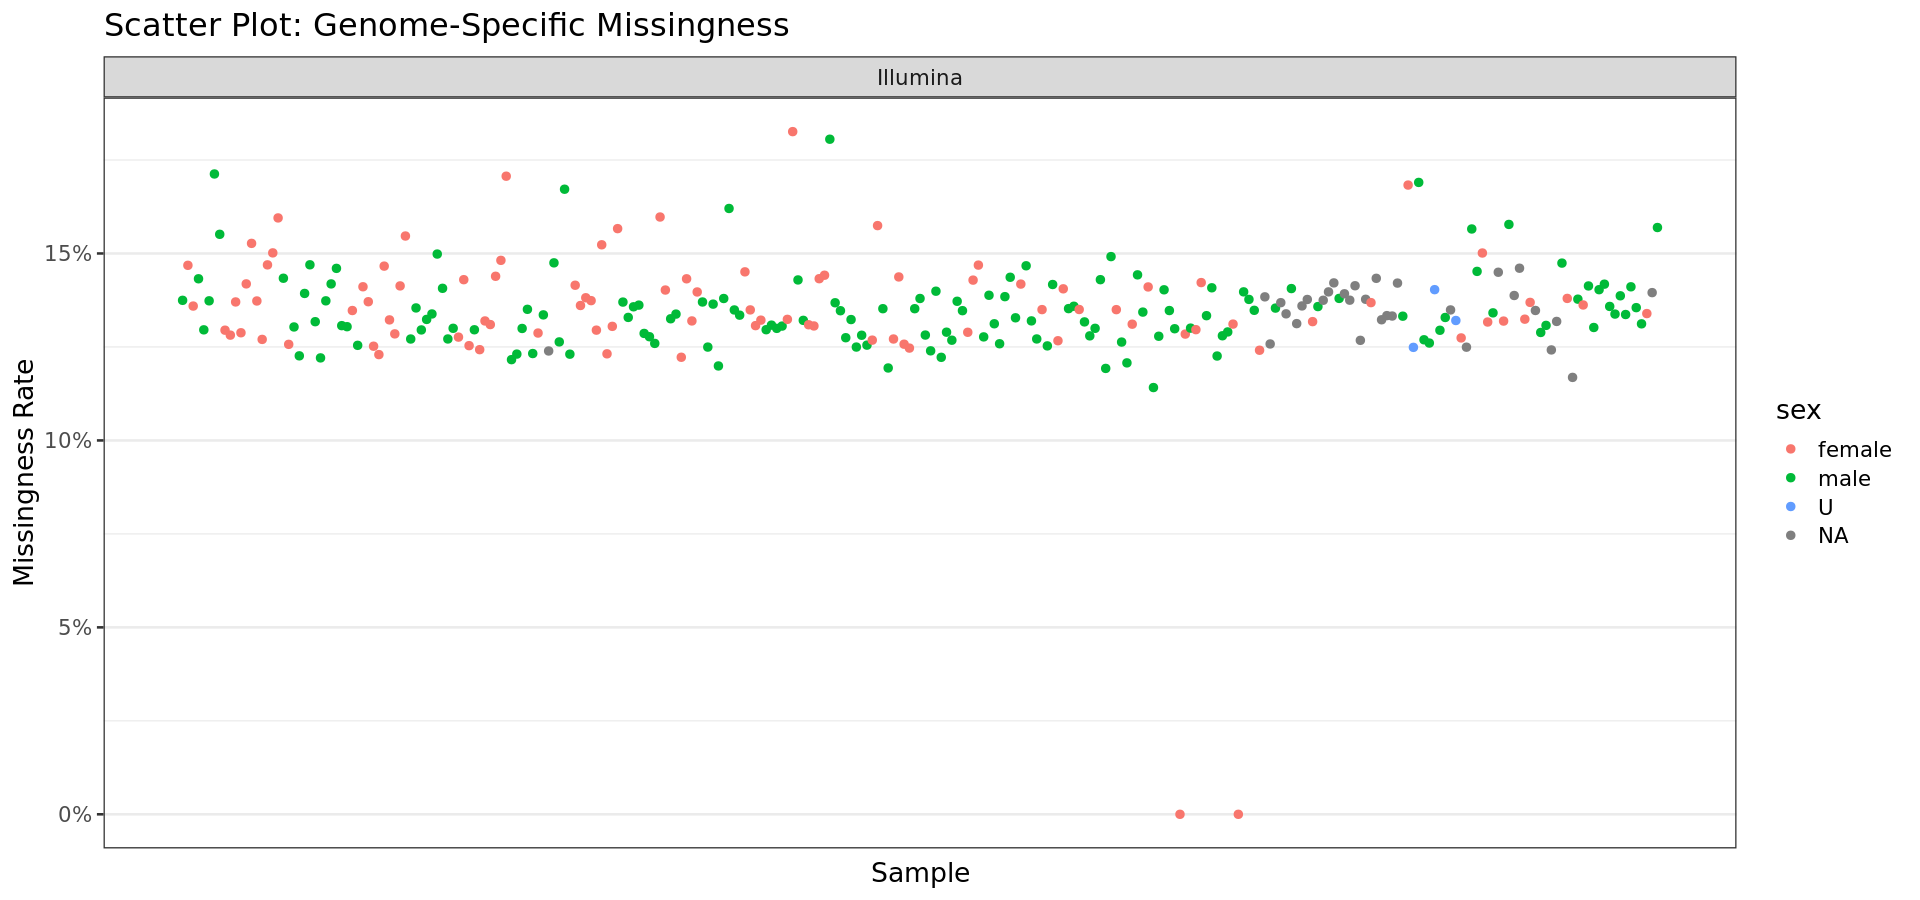

In [25]:
p <- joined_genome_results %>%
  ggplot(aes(x = name, y = missingness_rate, color = sex)) +
  geom_point() +
  scale_x_discrete(expand = c(0.05, 1)) +
  scale_y_continuous(limits = c(0, NA), labels = percent_format()) +
  facet_wrap(. ~ sequencing_platform, ncol = 1, scales = 'free') +
  xlab('Sample') +
  ylab('Missingness Rate') +
  ggtitle('Scatter Plot: Genome-Specific Missingness')
if (nrow(joined_genome_results) <= 20) {
  p + theme(axis.text.x = element_text(angle = 50, hjust = 1))
} else {
  p + theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(),
            panel.grid.major.x = element_blank())
}

## Display outliers 

In [26]:
(missingness_summary <- joined_genome_results %>%
    group_by(sequencing_platform) %>%
    summarize(
        missingness_rate_mean = mean(missingness_rate),
        missingness_rate_sd = sd(missingness_rate),
    ))

sequencing_platform,missingness_rate_mean,missingness_rate_sd
<chr>,<dbl>,<dbl>
Illumina,0.13484,0.01535446


In [27]:
low_missingness_sd_multiplier <- 3

(low_missingness_outliers <- joined_genome_results %>%
     inner_join(missingness_summary) %>%
     filter(
         missingness_rate < missingness_rate_mean - (low_missingness_sd_multiplier * missingness_rate_sd)
     ) %>%
     arrange(missingness_rate))

Joining, by = "sequencing_platform"


...1,name,no_calls,all_calls,missingness_rate,private_variant_count,heterozygous_variant_count,perct_het_alt_in_snvs,perct_hom_alt_in_snvs,hom_AA_count,het_RA_count,sequencing_platform,sex,ancestry,missingness_rate_mean,missingness_rate_sd
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
189,LP6005443-DNA_F11,0,3933469,0,NA,NA,NA,NA,NA,NA,Illumina,female,America,0.13484,0.01535446
200,LP6005443-DNA_H03,0,4020324,0,NA,NA,NA,NA,NA,NA,Illumina,female,CentralAsiaSiberia,0.13484,0.01535446


In [28]:
high_missingness_sd_multiplier <- 3

(high_missingness_outliers <- joined_genome_results %>%
     inner_join(missingness_summary) %>%
     filter(missingness_rate > missingness_rate_mean + (high_missingness_sd_multiplier * missingness_rate_sd)) %>%
     arrange(desc(missingness_rate)))

Joining, by = "sequencing_platform"


...1,name,no_calls,all_calls,missingness_rate,private_variant_count,heterozygous_variant_count,perct_het_alt_in_snvs,perct_hom_alt_in_snvs,hom_AA_count,het_RA_count,sequencing_platform,sex,ancestry,missingness_rate_mean,missingness_rate_sd
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
116,LP6005442-DNA_F01,751115,4113717,0.1825879,26798,1346092,0.599,0.401,24889,37170,Illumina,female,CentralAsiaSiberia,0.13484,0.01535446


In [29]:
problems <- rbind(
    tibble(name = unique(high_missingness_outliers$name),
           fail = str_glue('per genome missingness rate is at least {high_missingness_sd_multiplier}',
                           ' standard deviations above the platform mean')),
    tibble(name = unique(low_missingness_outliers$name),
           fail = str_glue('per genome missingness rate is at least {low_missingness_sd_multiplier}',
                           ' standard deviations below the platform mean')),
    problems)

dim(problems)
head(problems)

[1] 12  2

name,fail
<chr>,<glue>
LP6005442-DNA_F01,per genome missingness rate is at least 3 standard deviations above the platform mean
LP6005443-DNA_F11,per genome missingness rate is at least 3 standard deviations below the platform mean
LP6005443-DNA_H03,per genome missingness rate is at least 3 standard deviations below the platform mean
LP6005441-DNA_B03,per chrom variant count is at least 3 standard deviations below the platform mean for 12
LP6005441-DNA_G09,per chrom variant count is at least 3 standard deviations below the platform mean for X
LP6005442-DNA_C10,per chrom variant count is at least 3 standard deviations below the platform mean for X


# Singleton rate

Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2 rows containing non-finite values (stat_summary).”


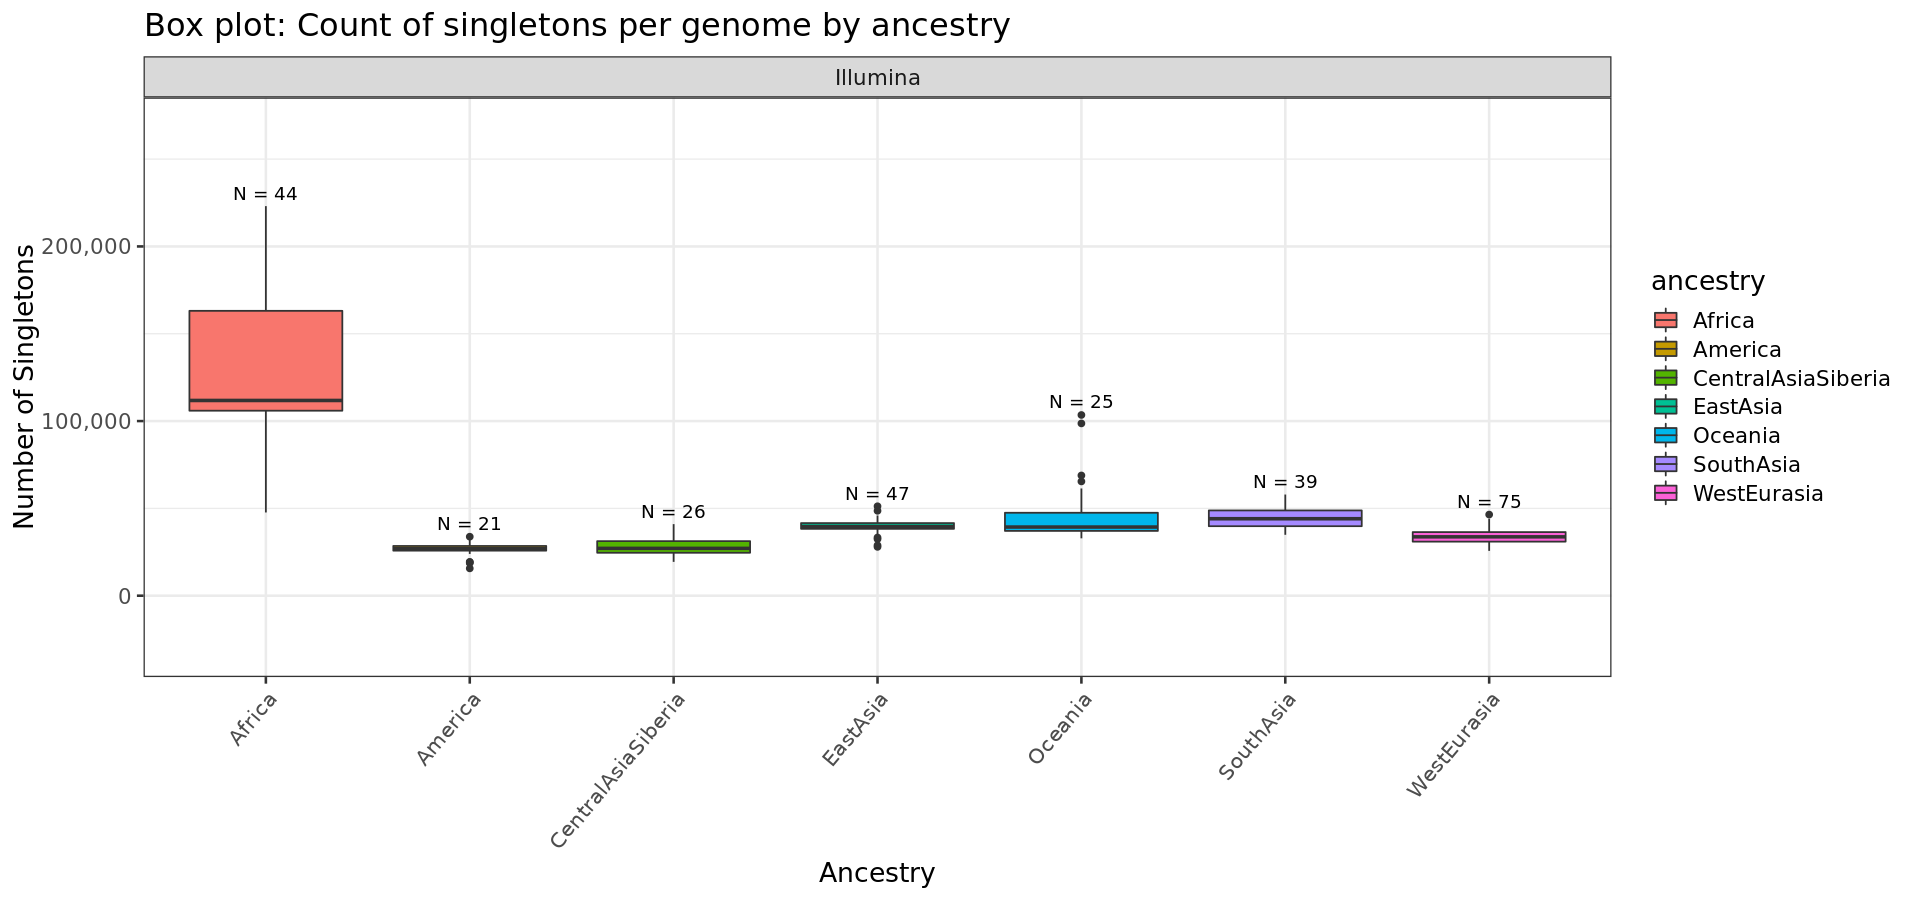

In [30]:
joined_genome_results %>%
  ggplot(aes(y = private_variant_count, x = ancestry, fill = ancestry)) +
  geom_boxplot() +
  stat_summary(fun.data = get_boxplot_fun_data, geom = 'text',
               position = position_dodge(width = 0.9), vjust = -0.5) +
  facet_wrap(. ~ sequencing_platform, ncol = 1, scales = 'free_y') +
  scale_y_continuous(labels = comma, expand = c(0.3, 0)) +
  ylab('Number of Singletons') +
  xlab('Ancestry') +
  ggtitle('Box plot: Count of singletons per genome by ancestry') +
  theme(axis.text.x = element_text(angle = 50, hjust = 1))

Warning message:
“Removed 2 rows containing missing values (geom_point).”


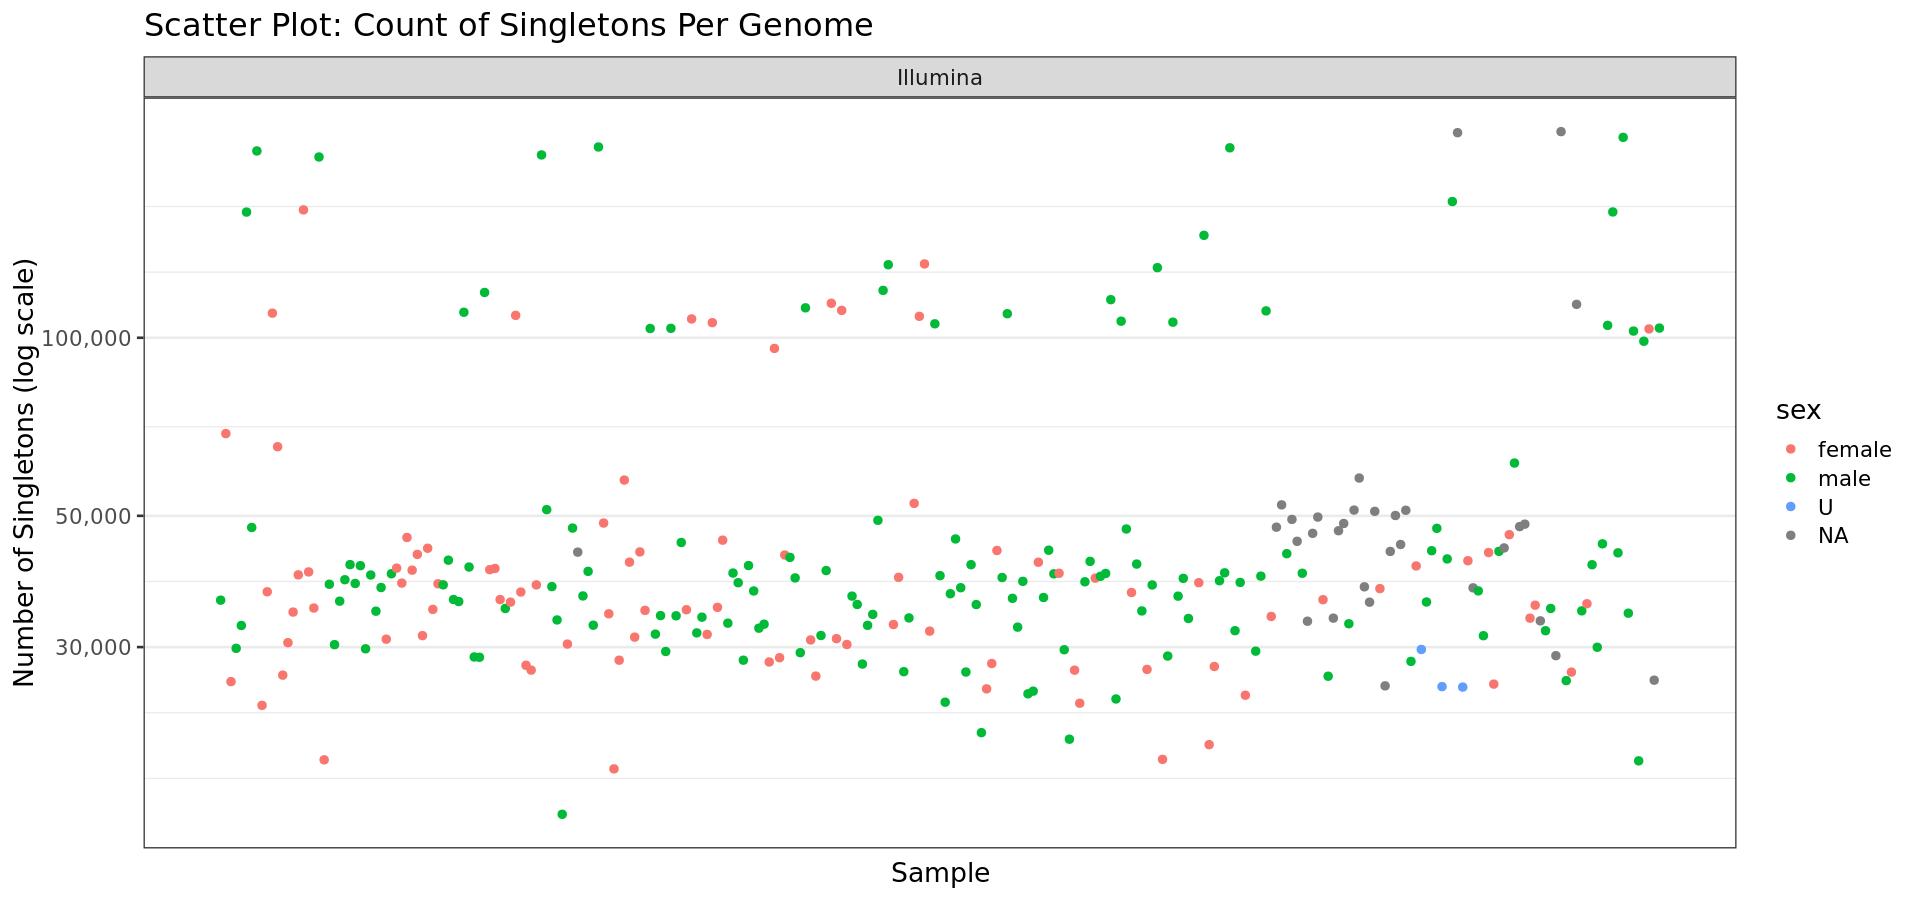

In [31]:
p <- joined_genome_results %>%
  ggplot(aes(x = name, y = private_variant_count, color = sex)) +
  geom_point() +
  scale_x_discrete(expand = c(0.05, 1)) +
  scale_y_log10(labels = comma) +
  facet_wrap(. ~ sequencing_platform, ncol = 1, scales = 'free') +
  xlab('Sample') +
  ylab('Number of Singletons (log scale)') +
  ggtitle('Scatter Plot: Count of Singletons Per Genome')
if (nrow(joined_genome_results) <= 20) {
  p + theme(axis.text.x = element_text(angle = 50, hjust = 1))
} else {
  p + theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(),
            panel.grid.major.x = element_blank())
}

## Display outliers 

In [32]:
(singleton_summary <- joined_genome_results %>%
     group_by(sequencing_platform, ancestry) %>%
     summarize(
         singleton_count_mean = mean(private_variant_count),
         singleton_count_sd = sd(private_variant_count),
     ))

`summarise()` has grouped output by 'sequencing_platform'. You can override
using the `.groups` argument.


sequencing_platform,ancestry,singleton_count_mean,singleton_count_sd
<chr>,<chr>,<dbl>,<dbl>
Illumina,Africa,129941.91,47340.445
Illumina,America,NA,NA
Illumina,CentralAsiaSiberia,NA,NA
Illumina,EastAsia,39639.74,4331.256
Illumina,Oceania,47300.68,18688.494
Illumina,SouthAsia,44108.92,5729.143
Illumina,WestEurasia,34190.81,4668.445


In [33]:
high_singleton_sd_multiplier <- 3

(high_singleton_outliers <- joined_genome_results %>%
     inner_join(singleton_summary) %>%
     filter(private_variant_count > singleton_count_mean + (high_singleton_sd_multiplier * singleton_count_sd)) %>%
     arrange(desc(private_variant_count)))

Joining, by = c("sequencing_platform", "ancestry")


...1,name,no_calls,all_calls,missingness_rate,private_variant_count,heterozygous_variant_count,perct_het_alt_in_snvs,perct_hom_alt_in_snvs,hom_AA_count,het_RA_count,sequencing_platform,sex,ancestry,singleton_count_mean,singleton_count_sd
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
277,SS6004478,550395,4109729,0.1339249,103490,1372511,0.51,0.49,35219,36586,Illumina,female,Oceania,47300.68,18688.49


In [34]:
problems <- rbind(
    tibble(name = high_singleton_outliers$name,
           fail = str_glue('singleton count at least {high_singleton_sd_multiplier}',
           ' standard deviations above the ancestry and platform mean')),
    problems)

dim(problems)
head(problems)

[1] 13  2

name,fail
<chr>,<glue>
SS6004478,singleton count at least 3 standard deviations above the ancestry and platform mean
LP6005442-DNA_F01,per genome missingness rate is at least 3 standard deviations above the platform mean
LP6005443-DNA_F11,per genome missingness rate is at least 3 standard deviations below the platform mean
LP6005443-DNA_H03,per genome missingness rate is at least 3 standard deviations below the platform mean
LP6005441-DNA_B03,per chrom variant count is at least 3 standard deviations below the platform mean for 12
LP6005441-DNA_G09,per chrom variant count is at least 3 standard deviations below the platform mean for X


# Heterozygosity rate

Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2 rows containing non-finite values (stat_summary).”


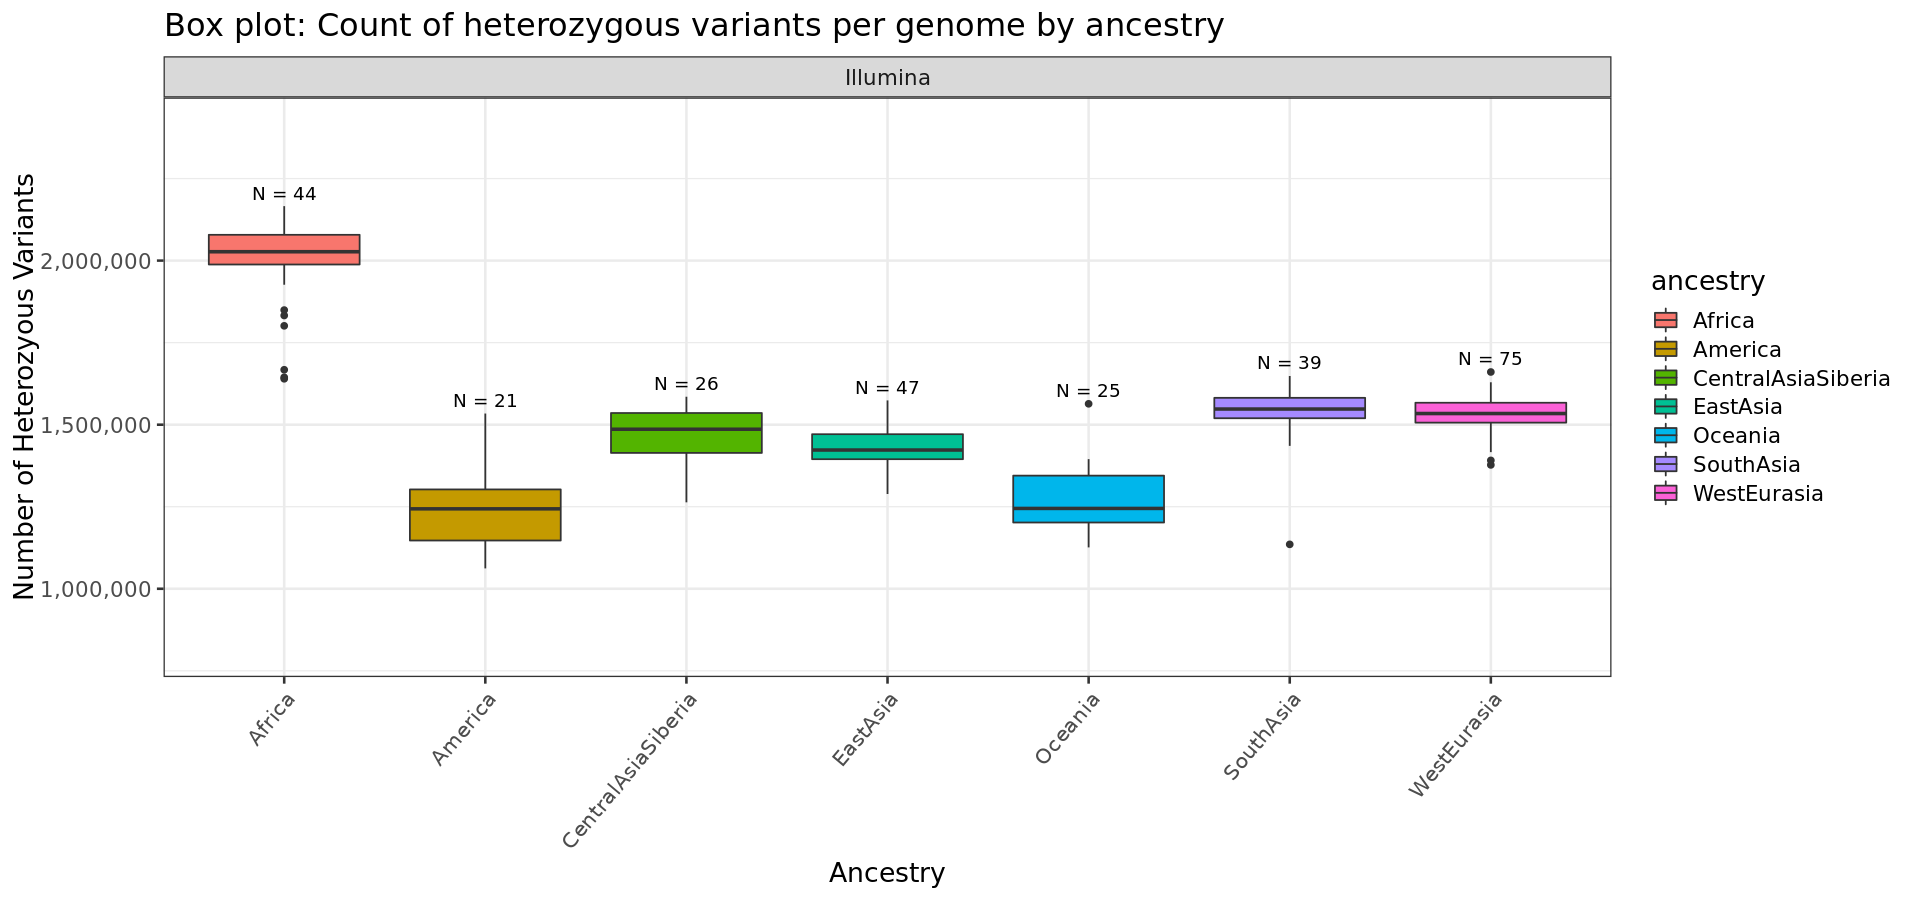

In [35]:
ggplot(joined_genome_results,
       aes(y = heterozygous_variant_count, x = ancestry, fill = ancestry)) +
  geom_boxplot() +
  stat_summary(fun.data = get_boxplot_fun_data, geom = 'text',
               position = position_dodge(width = 0.9), vjust = -0.5) +
  scale_y_continuous(labels = comma, expand = c(0.3, 0)) +
  facet_wrap(. ~ sequencing_platform, ncol = 1, scales = 'free_y') +
  ylab('Number of Heterozyous Variants') +
  xlab('Ancestry') +
  ggtitle('Box plot: Count of heterozygous variants per genome by ancestry') +
  theme(axis.text.x = element_text(angle = 50, hjust = 1))

Warning message:
“Removed 2 rows containing missing values (geom_point).”


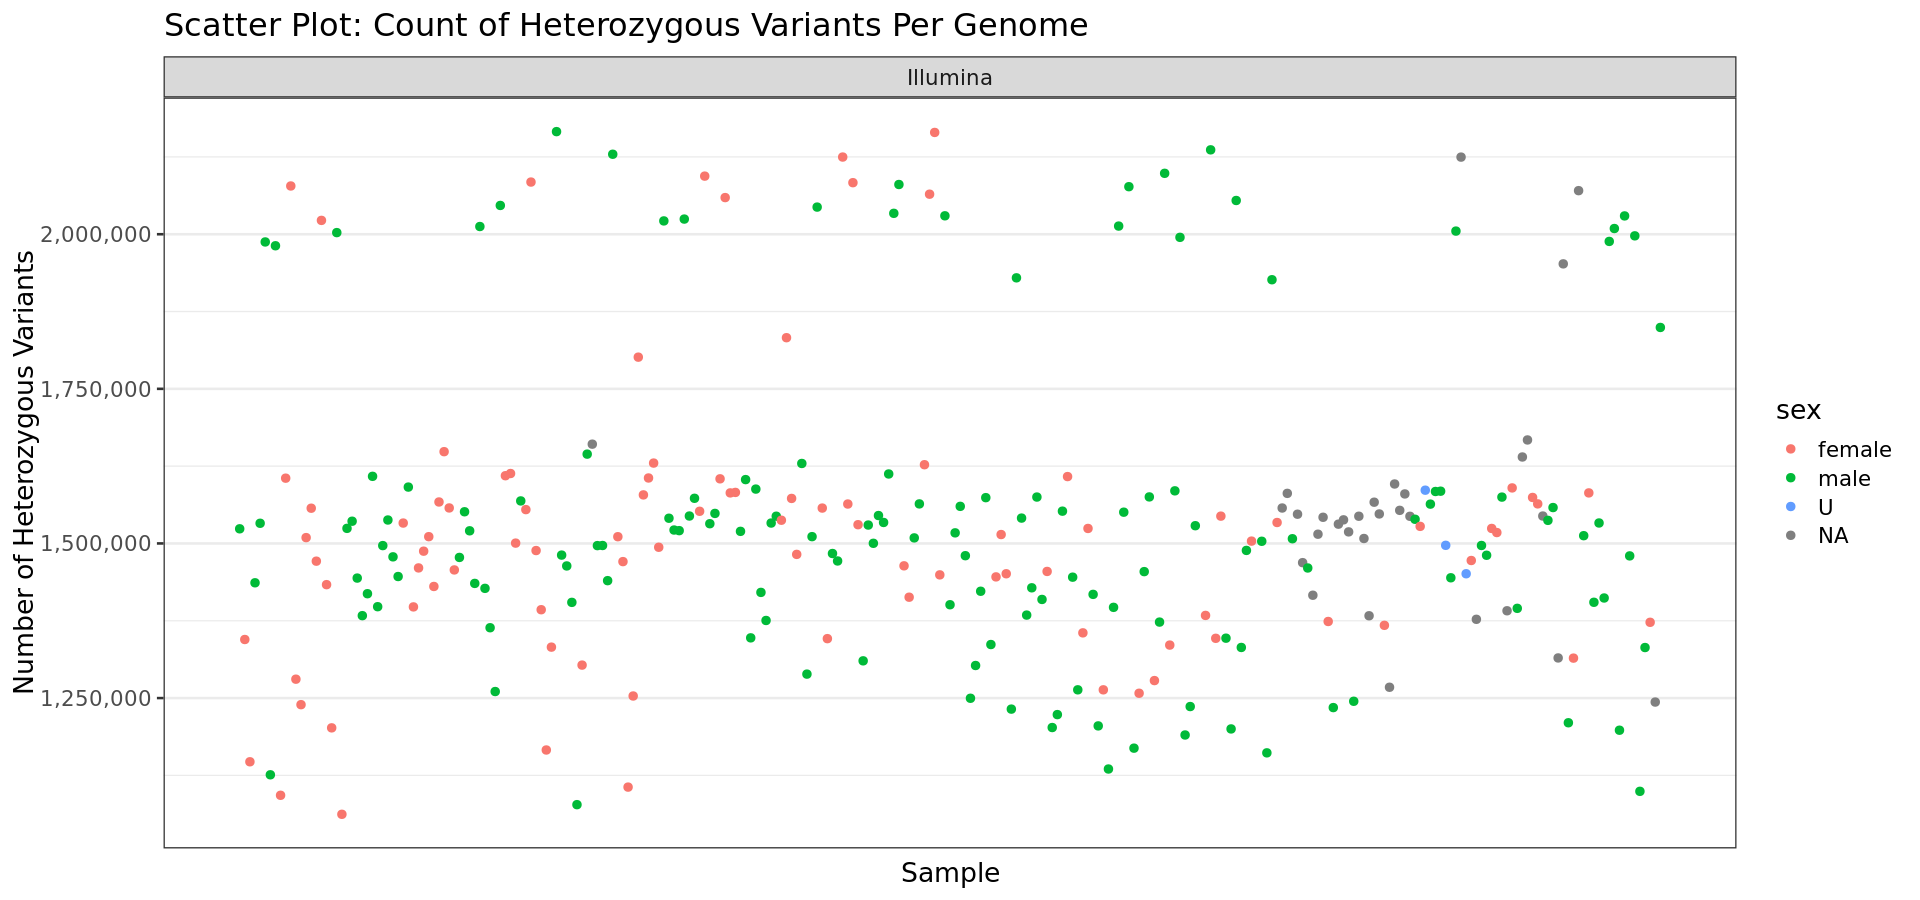

In [36]:
p <- ggplot(joined_genome_results) +
  geom_point(aes(x = name, y = heterozygous_variant_count, color = sex)) +
  scale_x_discrete(expand = c(0.05, 1)) +
  scale_y_continuous(labels = comma) +
  facet_wrap(. ~ sequencing_platform, ncol = 1, scales = 'free') +
  xlab('Sample') +
  ylab('Number of Heterozygous Variants') +
  ggtitle('Scatter Plot: Count of Heterozygous Variants Per Genome')
if (nrow(joined_genome_results) <= 20) {
  p + theme(axis.text.x = element_text(angle = 50, hjust = 1))
} else {
  p + theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(),
            panel.grid.major.x = element_blank())
}

## Display outliers 

In [37]:
(heterozygous_variant_count_summary <- joined_genome_results %>%
    group_by(sequencing_platform, ancestry) %>%
    summarize(
        heterozygous_variant_count_mean = mean(heterozygous_variant_count),
        heterozygous_variant_count_sd = sd(heterozygous_variant_count),
    ))

`summarise()` has grouped output by 'sequencing_platform'. You can override
using the `.groups` argument.


sequencing_platform,ancestry,heterozygous_variant_count_mean,heterozygous_variant_count_sd
<chr>,<chr>,<dbl>,<dbl>
Illumina,Africa,2004011,124492.59
Illumina,America,NA,NA
Illumina,CentralAsiaSiberia,NA,NA
Illumina,EastAsia,1428578,58931.13
Illumina,Oceania,1270962,98640.50
Illumina,SouthAsia,1538952,83020.18
Illumina,WestEurasia,1533601,52577.87


In [38]:
low_het_count_sd_multiplier <- 3

(low_heterozygous_variant_count_outliers <- joined_genome_results %>%
     inner_join(heterozygous_variant_count_summary) %>%
     filter(heterozygous_variant_count
            < heterozygous_variant_count_mean - (low_het_count_sd_multiplier * heterozygous_variant_count_sd)
     ) %>%
     arrange(heterozygous_variant_count))

Joining, by = c("sequencing_platform", "ancestry")


...1,name,no_calls,all_calls,missingness_rate,private_variant_count,heterozygous_variant_count,perct_het_alt_in_snvs,perct_hom_alt_in_snvs,hom_AA_count,het_RA_count,sequencing_platform,sex,ancestry,heterozygous_variant_count_mean,heterozygous_variant_count_sd
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
171,LP6005443-DNA_D09,510134,3873589,0.1316954,39514,1135303,0.009,0.991,53132,472,Illumina,male,SouthAsia,1538952,83020.18


In [39]:
high_het_count_sd_multiplier <- 3

(high_heterozygous_variant_count_outliers <- joined_genome_results %>%
     inner_join(heterozygous_variant_count_summary) %>%
     filter(heterozygous_variant_count
            > heterozygous_variant_count_mean + (high_het_count_sd_multiplier * heterozygous_variant_count_sd)
     ) %>%
     arrange(desc(heterozygous_variant_count)))

Joining, by = c("sequencing_platform", "ancestry")


...1,name,no_calls,all_calls,missingness_rate,private_variant_count,heterozygous_variant_count,perct_het_alt_in_snvs,perct_hom_alt_in_snvs,hom_AA_count,het_RA_count,sequencing_platform,sex,ancestry,heterozygous_variant_count_mean,heterozygous_variant_count_sd
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>


In [40]:
problems <- rbind(
    tibble(name = low_heterozygous_variant_count_outliers$name,
           fail = str_glue('heterozygous variant count at least {low_het_count_sd_multiplier}',
                           ' standard deviations below the ancestry and platform mean')),
    tibble(name = high_heterozygous_variant_count_outliers$name,
           fail = str_glue('heterozygous variant count at least {high_het_count_sd_multiplier}',
                           ' standard deviations above the ancestry and platform mean')),
    problems)

dim(problems)
head(problems)

[1] 14  2

name,fail
<chr>,<glue>
LP6005443-DNA_D09,heterozygous variant count at least 3 standard deviations below the ancestry and platform mean
SS6004478,singleton count at least 3 standard deviations above the ancestry and platform mean
LP6005442-DNA_F01,per genome missingness rate is at least 3 standard deviations above the platform mean
LP6005443-DNA_F11,per genome missingness rate is at least 3 standard deviations below the platform mean
LP6005443-DNA_H03,per genome missingness rate is at least 3 standard deviations below the platform mean
LP6005441-DNA_B03,per chrom variant count is at least 3 standard deviations below the platform mean for 12


# Homozygosity rate

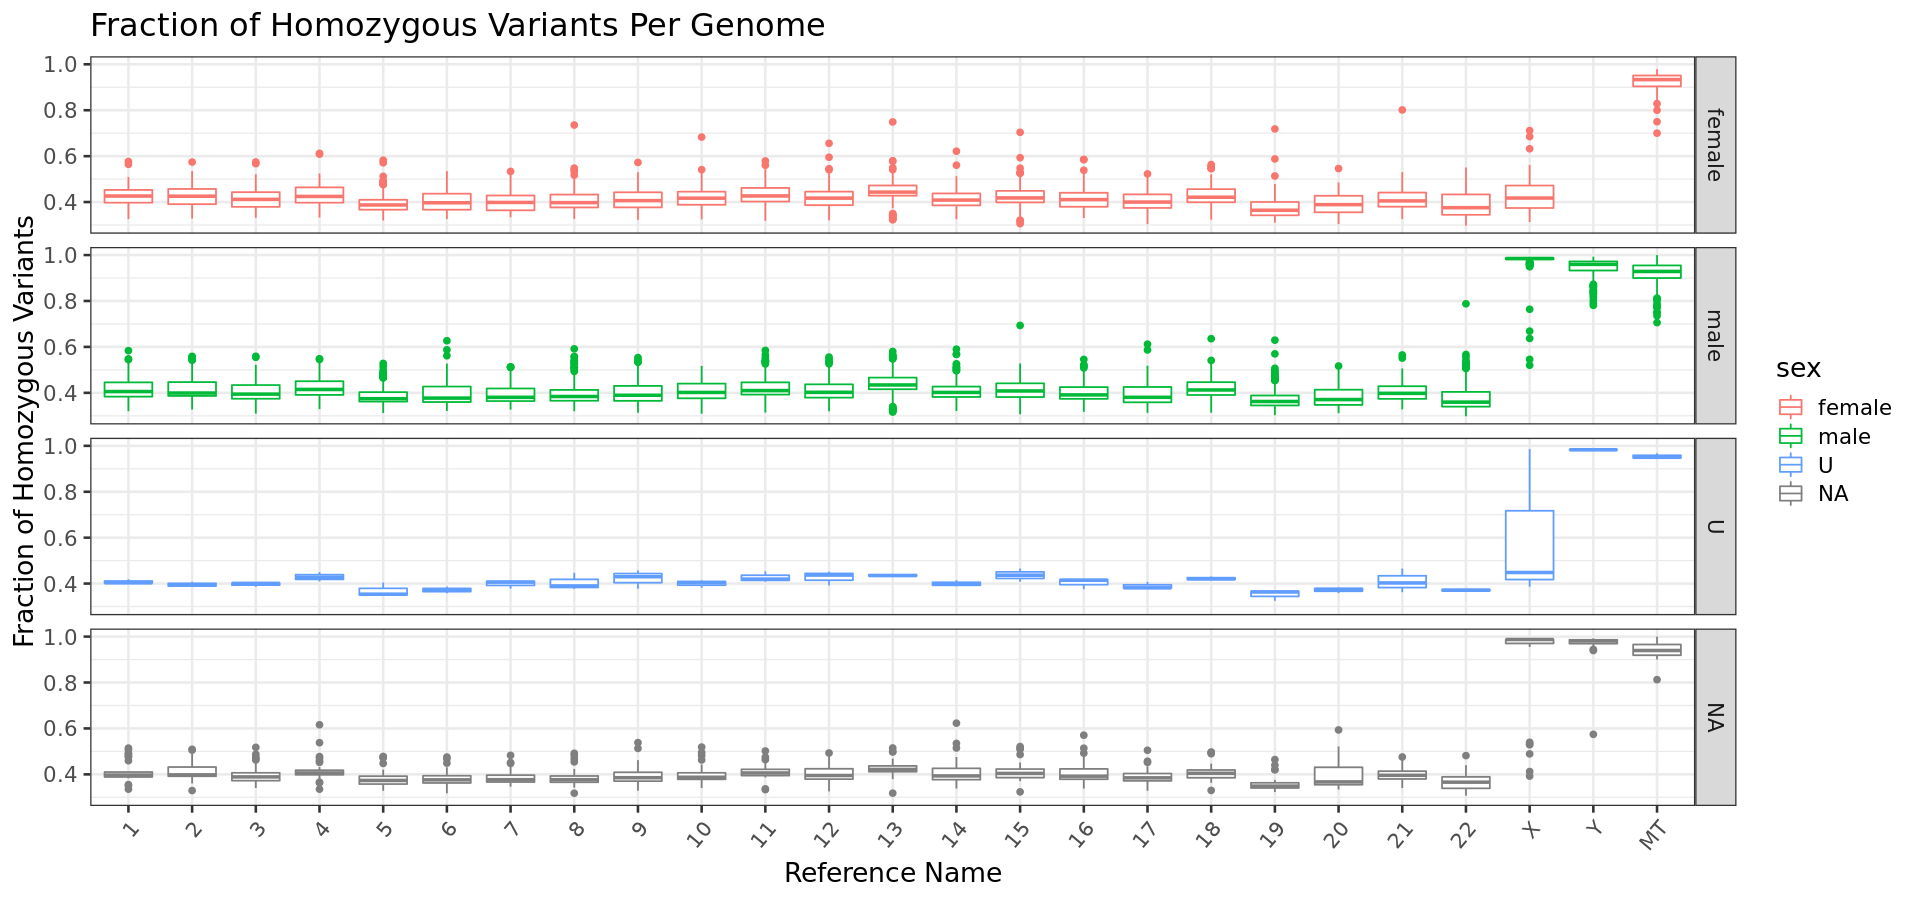

In [41]:
joined_chrom_results %>%
  filter(reference_name %in% c(AUTOSOMES, ALLOSOMES, MITOCHONDRIA)) %>%
  mutate(reference_name = parse_factor(reference_name, levels = c(AUTOSOMES, ALLOSOMES, MITOCHONDRIA))) %>%
  ggplot(aes(y = F, x = reference_name, color = sex)) +
  geom_boxplot() +
  facet_grid(sex ~ .) +
  ylab('Fraction of Homozygous Variants') +
  xlab('Reference Name') +
  ggtitle('Fraction of Homozygous Variants Per Genome') +
  theme(axis.text.x = element_text(angle = 50, hjust = 1))

In [42]:
head(fraction_homozygous_summary <- joined_chrom_results %>%
    group_by(reference_name) %>%
    summarize(
        F_mean = mean(F),
        F_sd = sd(F),
    ))

reference_name,F_mean,F_sd
<chr>,<dbl>,<dbl>
1,0.4188419,0.05076990
10,0.4111918,0.04964400
11,0.4221581,0.05315690
12,0.4158390,0.05427126
13,0.4404229,0.05769077
14,0.4116191,0.05125374


## Display per-chromosome outliers 

In [43]:
low_fraction_homozygous_sd_multiplier <- 4

(low_hom_outliers <- joined_chrom_results %>%
    inner_join(fraction_homozygous_summary) %>%
    filter(F < F_mean - (low_fraction_homozygous_sd_multiplier * F_sd)) %>%
    arrange(sex, reference_name, F))

Joining, by = "reference_name"


...1,name,reference_name,number_of_calls,HOM_ALT,HAS_ALT,N_SITES,F,transitions,transversions,titv,sequencing_platform,sex,ancestry,F_mean,F_sd
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
3680,LP6005443-DNA_B06,MT,10,7,10,10,0.70000,8,2,4.000000,Illumina,female,WestEurasia,0.9222295,0.05258101
3481,LP6005443-DNA_A06,MT,17,12,17,17,0.70588,13,4,3.250000,Illumina,male,WestEurasia,0.9222295,0.05258101
6073,LP6005592-DNA_G03,Y,975,560,975,975,0.57436,562,413,1.360775,Illumina,NA,WestEurasia,0.9462340,0.05181015


In [44]:
high_fraction_homozygous_sd_multiplier <- 4

(high_hom_outliers <- joined_chrom_results %>%
    inner_join(fraction_homozygous_summary) %>%
    filter(F > F_mean + (high_fraction_homozygous_sd_multiplier * F_sd)) %>%
    arrange(sex, reference_name, desc(F)))

Joining, by = "reference_name"


...1,name,reference_name,number_of_calls,HOM_ALT,HAS_ALT,N_SITES,F,transitions,transversions,titv,sequencing_platform,sex,ancestry,F_mean,F_sd
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
489,LP6005441-DNA_B12,10,108474,74093,108474,108474,0.68305,74360,34114,2.179750,Illumina,female,America,0.4111918,0.04964400
53,LP6005441-DNA_A04,12,101085,66293,101085,101085,0.65581,69610,31475,2.211597,Illumina,female,America,0.4158390,0.05427126
203,LP6005441-DNA_A12,13,85354,63926,85354,85354,0.74895,57955,27399,2.115223,Illumina,female,America,0.4404229,0.05769077
55,LP6005441-DNA_A04,14,70962,44091,70962,70962,0.62133,48516,22446,2.161454,Illumina,female,America,0.4116191,0.05125374
1500,LP6005441-DNA_F12,15,58928,41473,58928,58928,0.70379,39970,18958,2.108345,Illumina,female,EastAsia,0.4170724,0.05481585
209,LP6005441-DNA_A12,19,34596,24856,34596,34596,0.71846,24207,10389,2.330061,Illumina,female,America,0.3747367,0.05114097
1480,LP6005441-DNA_F10,19,34294,20158,34294,34294,0.58780,23890,10404,2.296232,Illumina,female,America,0.3747367,0.05114097
4851,LP6005443-DNA_H02,21,28969,23209,28969,28969,0.80117,19708,9261,2.128064,Illumina,female,CentralAsiaSiberia,0.4075964,0.04901320
216,LP6005441-DNA_A12,5,140029,81562,140029,140029,0.58247,94244,45785,2.058403,Illumina,female,America,0.3894773,0.04727087


In [45]:
problems <- rbind(
    low_hom_outliers %>%
    group_by(name) %>%
    summarize(fail = str_glue('per chrom homozygosity is at least {low_fraction_homozygous_sd_multiplier}',
                               ' standard deviations below the mean ',
                              str_c(reference_name, collapse = ','))),
    high_hom_outliers %>%
    group_by(name) %>%
    summarize(fail = str_glue('per chrom homozygosity is at least {high_fraction_homozygous_sd_multiplier}',
                               ' standard deviations above the mean ',
                              str_c(reference_name, collapse = ','))),
    problems)

dim(problems)
head(problems)

[1] 31  2

name,fail
<chr>,<glue>
LP6005443-DNA_A06,per chrom homozygosity is at least 4 standard deviations below the mean MT
LP6005443-DNA_B06,per chrom homozygosity is at least 4 standard deviations below the mean MT
LP6005592-DNA_G03,per chrom homozygosity is at least 4 standard deviations below the mean Y
LP6005441-DNA_A04,"per chrom homozygosity is at least 4 standard deviations above the mean 12,14"
LP6005441-DNA_A05,per chrom homozygosity is at least 4 standard deviations above the mean 19
LP6005441-DNA_A12,"per chrom homozygosity is at least 4 standard deviations above the mean 13,19,5"


# Ti/Tv ratio per chromosome

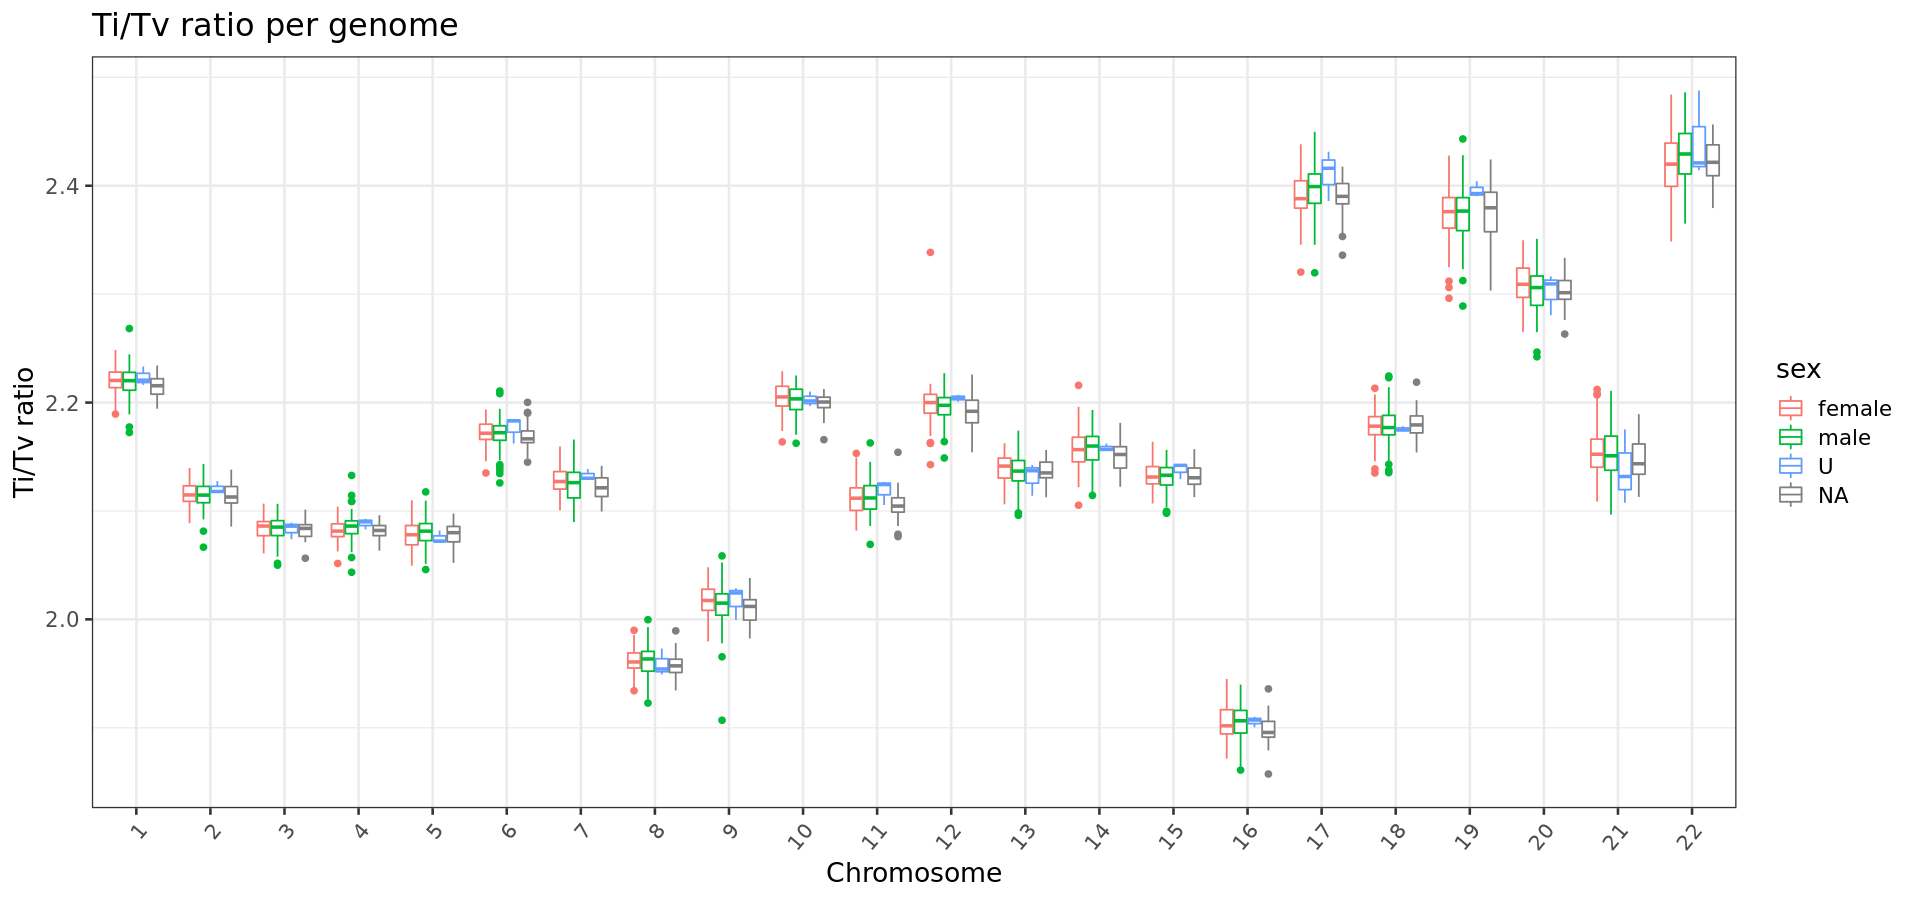

In [46]:
joined_chrom_results %>%
  filter(reference_name %in% c(AUTOSOMES)) %>%
  mutate(reference_name = parse_factor(reference_name, levels = c(AUTOSOMES))) %>%
  ggplot(aes(y = titv, x = reference_name, color = sex)) +
  geom_boxplot() +
  ylab('Ti/Tv ratio') +
  xlab('Chromosome') +
  ggtitle('Ti/Tv ratio per genome') +
  theme(axis.text.x = element_text(angle = 50, hjust = 1))

## Display per-chromosome outliers 

In [47]:
titv_summary <- joined_chrom_results %>%
    group_by(reference_name) %>%
    summarize(
        titv_mean = mean(titv),
        titv_sd = sd(titv),
    )

head(titv_summary)

reference_name,titv_mean,titv_sd
<chr>,<dbl>,<dbl>
1,2.219252,0.01258482
10,2.202867,0.01241526
11,2.111731,0.01504897
12,2.196549,0.01564716
13,2.137940,0.01309361
14,2.157042,0.01730380


In [48]:
low_titv_sd_multiplier <- 4

(low_titv_outliers <- joined_chrom_results %>%
    inner_join(titv_summary) %>%
    filter(titv < titv_mean - (low_titv_sd_multiplier * titv_sd)) %>%
    arrange(reference_name, titv))

Joining, by = "reference_name"


...1,name,reference_name,number_of_calls,HOM_ALT,HAS_ALT,N_SITES,F,transitions,transversions,titv,sequencing_platform,sex,ancestry,titv_mean,titv_sd
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
6109,LP6005592-DNA_H03,2,206100,88676,206100,206100,0.43026,138892,67208,2.066599,Illumina,male,Oceania,2.115257,0.011184957
6114,LP6005592-DNA_H03,4,186016,83410,186016,186016,0.44840,124896,61120,2.043455,Illumina,male,Oceania,2.083788,0.009898056
6588,SS6004471,9,73619,26039,73619,73619,0.35370,48294,25325,1.906969,Illumina,male,Africa,2.014215,0.016098735
1739,LP6005441-DNA_G10,X,51934,49354,51934,51934,0.95032,33785,18149,1.861535,Illumina,male,WestEurasia,2.054405,0.035042037
172,LP6005441-DNA_A10,X,55095,52322,55095,55095,0.94967,35945,19150,1.877023,Illumina,male,Oceania,2.054405,0.035042037
2548,LP6005442-DNA_D01,X,50156,48158,50156,50156,0.96016,32779,17377,1.886344,Illumina,male,EastAsia,2.054405,0.035042037
6121,LP6005592-DNA_H03,X,51989,49687,51989,51989,0.95572,34119,17870,1.909289,Illumina,male,Oceania,2.054405,0.035042037


In [49]:
high_titv_sd_multiplier <- 4

(high_titv_outliers <- joined_chrom_results %>%
    inner_join(titv_summary) %>%
    filter(titv > titv_mean + (high_titv_sd_multiplier * titv_sd)) %>%
    arrange(reference_name, desc(titv)))

Joining, by = "reference_name"


...1,name,reference_name,number_of_calls,HOM_ALT,HAS_ALT,N_SITES,F,transitions,transversions,titv,sequencing_platform,sex,ancestry,titv_mean,titv_sd
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>
4619,LP6005443-DNA_G01,12,6440,3386,6440,6440,0.52578,4511,1929,2.338517,Illumina,female,EastAsia,2.196549,0.015647164
2712,LP6005442-DNA_E04,4,181307,69166,181307,181307,0.38149,123433,57874,2.132788,Illumina,male,WestEurasia,2.083788,0.009898056


In [50]:
problems <- rbind(
    low_titv_outliers %>%
    group_by(name) %>%
    summarize(fail = str_glue('per chrom ti/tv is at least {low_titv_sd_multiplier} standard deviations below the mean for ',
                              str_c(reference_name, collapse = ','))),
    high_titv_outliers %>%
    group_by(name) %>%
    summarize(fail = str_glue('per chrom ti/tv is at least {high_titv_sd_multiplier} standard deviations above the mean for ',
                              str_c(reference_name, collapse = ','))),
    problems)

dim(problems)
head(problems)

[1] 38  2

name,fail
<chr>,<glue>
LP6005441-DNA_A10,per chrom ti/tv is at least 4 standard deviations below the mean for X
LP6005441-DNA_G10,per chrom ti/tv is at least 4 standard deviations below the mean for X
LP6005442-DNA_D01,per chrom ti/tv is at least 4 standard deviations below the mean for X
LP6005592-DNA_H03,"per chrom ti/tv is at least 4 standard deviations below the mean for 2,4,X"
SS6004471,per chrom ti/tv is at least 4 standard deviations below the mean for 9
LP6005442-DNA_E04,per chrom ti/tv is at least 4 standard deviations above the mean for 4


# Sex inference

Warning message:
“Removed 2 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 2 rows containing non-finite values (stat_summary).”


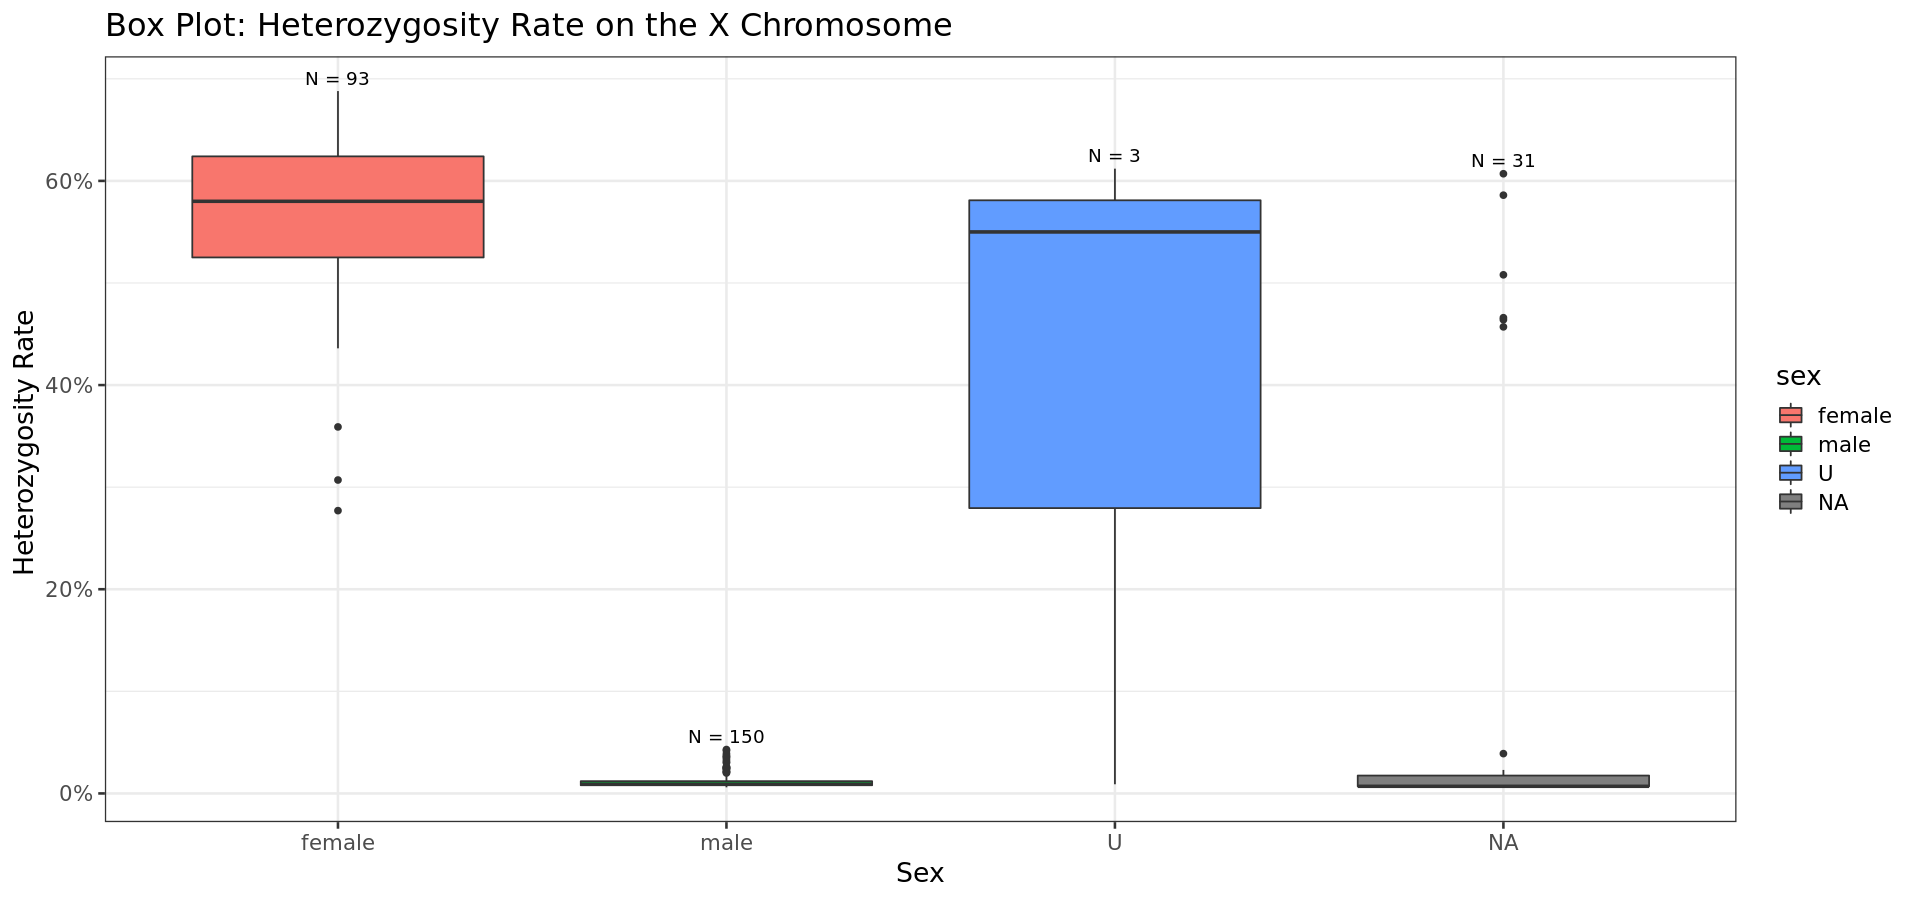

In [51]:
ggplot(joined_genome_results, aes(x = sex, y = perct_het_alt_in_snvs, fill = sex)) +
  geom_boxplot() +
  stat_summary(fun.data = get_boxplot_fun_data, geom = 'text', position = position_dodge(width = 0.9), vjust = -0.5) +
  scale_y_continuous(labels = percent_format()) +
  xlab('Sex') +
  ylab('Heterozygosity Rate ') +
  ggtitle('Box Plot: Heterozygosity Rate on the X Chromosome')

Warning message:
“Removed 2 rows containing missing values (geom_point).”


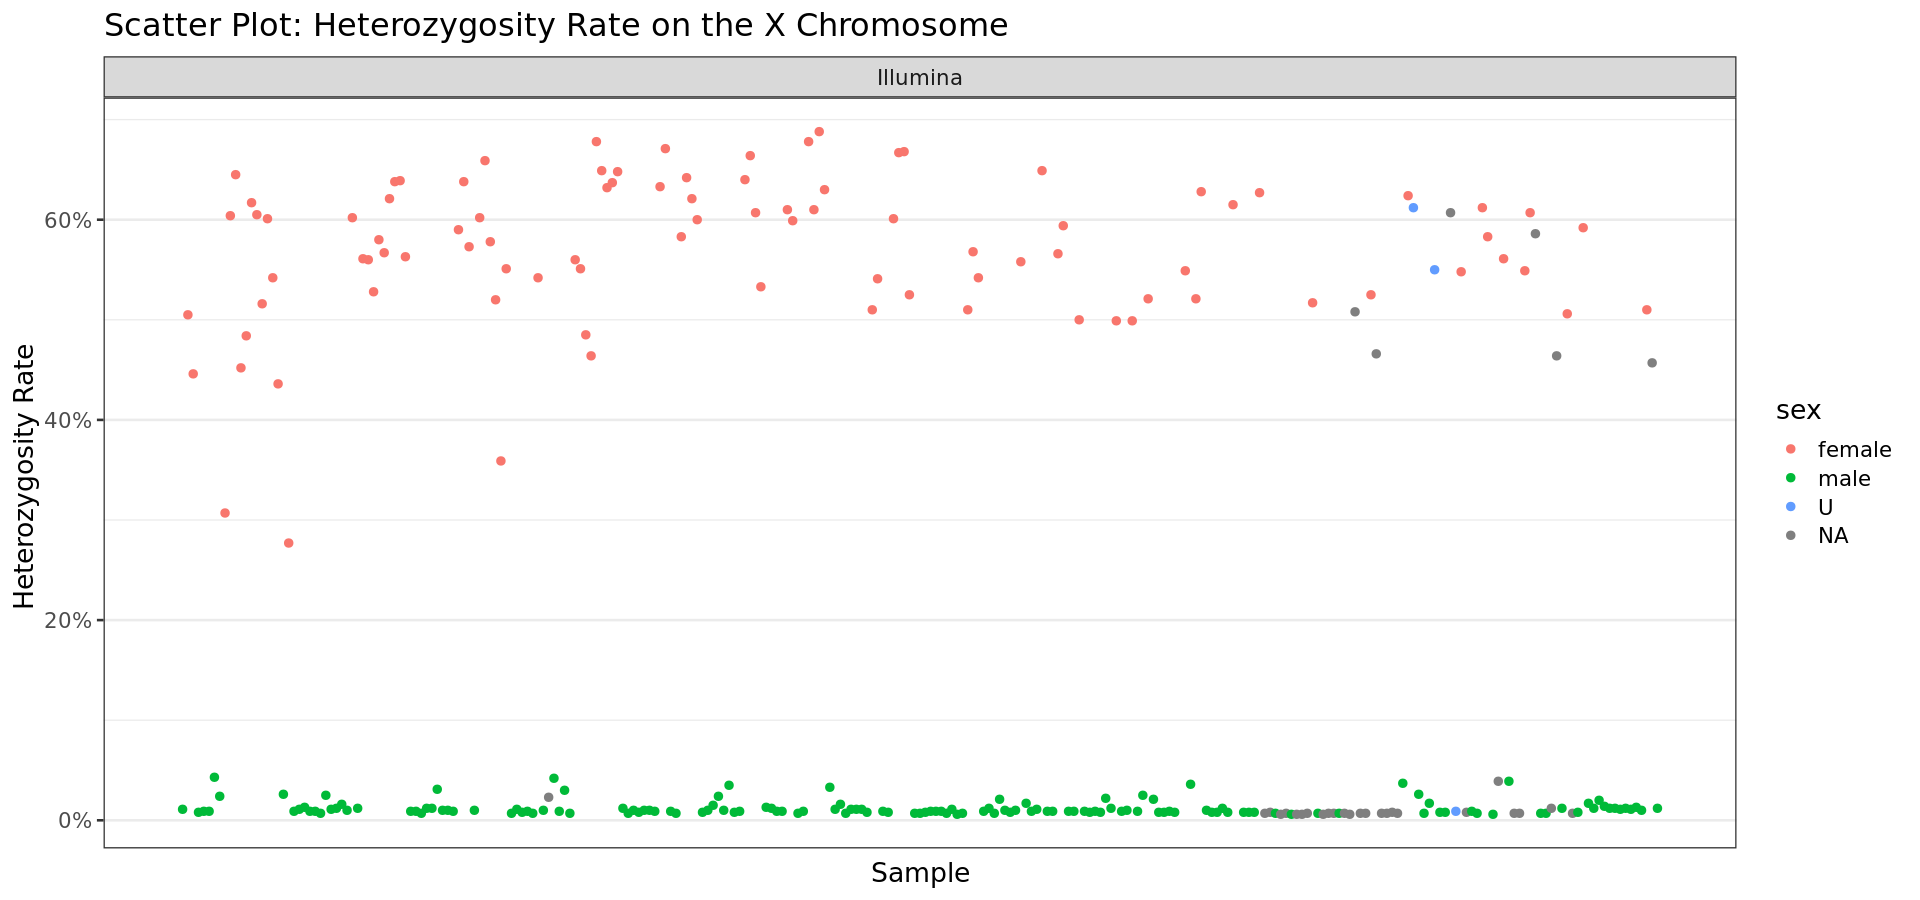

In [52]:
p <- ggplot(joined_genome_results) +
  geom_point(aes(x = name, y = perct_het_alt_in_snvs, color = sex)) +
  scale_x_discrete(expand = c(0.05, 1)) +
  scale_y_continuous(labels = percent_format()) +
  facet_wrap(. ~ sequencing_platform, ncol = 1, scales = 'free') +
  xlab('Sample') +
  ylab('Heterozygosity Rate ') +
  ggtitle('Scatter Plot: Heterozygosity Rate on the X Chromosome')
if (nrow(joined_genome_results) <= 20) {
  p + theme(axis.text.x = element_text(angle = 50, hjust = 1))
} else {
  p + theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(),
            panel.grid.major.x = element_blank())
}

## Display outliers 

In [53]:
(m_outliers <- joined_genome_results %>%
    filter(!sex %in% c('F', 'FEMALE', 'female') & perct_het_alt_in_snvs > 0.4) %>%
    arrange(desc(perct_het_alt_in_snvs))
)

...1,name,no_calls,all_calls,missingness_rate,private_variant_count,heterozygous_variant_count,perct_het_alt_in_snvs,perct_hom_alt_in_snvs,hom_AA_count,het_RA_count,sequencing_platform,sex,ancestry
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
233,LP6005592-DNA_B01,508980,4075598,0.1248847,29725,1586128,0.612,0.388,27275,43093,Illumina,U,WestEurasia
240,LP6005592-DNA_C05,723617,5364212,0.1348972,222136,2124679,0.607,0.393,48385,74738,Illumina,NA,Africa
256,LP6005677-DNA_B01,550627,4086208,0.1347526,33226,1544349,0.586,0.414,28956,40960,Illumina,NA,WestEurasia
237,LP6005592-DNA_C01,568630,4052343,0.1403213,25723,1496980,0.550,0.450,30240,36956,Illumina,U,WestEurasia
222,LP6005519-DNA_E06,572517,4049902,0.1413656,37932,1383080,0.508,0.492,33134,34166,Illumina,NA,Oceania
226,LP6005519-DNA_G02,566167,3949499,0.1433516,25800,1267478,0.466,0.534,36489,31894,Illumina,NA,America
260,LP6005677-DNA_D03,690484,5238023,0.1318215,223053,1952065,0.464,0.536,59261,51298,Illumina,NA,Africa
278,SS6004479,542368,3887179,0.1395274,26374,1243556,0.457,0.543,35051,29543,Illumina,NA,America


In [54]:
(f_outliers <- joined_genome_results %>%
    filter(! sex %in% c('M', 'MALE', 'male') & perct_het_alt_in_snvs < 0.4) %>%
    arrange(perct_het_alt_in_snvs))

...1,name,no_calls,all_calls,missingness_rate,private_variant_count,heterozygous_variant_count,perct_het_alt_in_snvs,perct_hom_alt_in_snvs,hom_AA_count,het_RA_count,sequencing_platform,sex,ancestry
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
208,LP6005519-DNA_B04,566925,4142976,0.1368400,49311,1547285,0.006,0.994,53098,330,Illumina,NA,SouthAsia
211,LP6005519-DNA_C03,527577,4020038,0.1312368,33178,1416275,0.006,0.994,50180,319,Illumina,NA,WestEurasia
212,LP6005519-DNA_C04,560349,4121190,0.1359678,46710,1514947,0.006,0.994,52994,312,Illumina,NA,SouthAsia
216,LP6005519-DNA_D03,561514,4084245,0.1374829,33580,1531195,0.006,0.994,49785,303,Illumina,NA,WestEurasia
221,LP6005519-DNA_E05,568875,4137079,0.1375064,57928,1508017,0.006,0.994,52651,337,Illumina,NA,SouthAsia
205,LP6005519-DNA_A04,575193,4156124,0.1383965,47842,1557311,0.007,0.993,54123,376,Illumina,NA,SouthAsia
209,LP6005519-DNA_B05,548318,4096440,0.1338523,45282,1468958,0.007,0.993,51976,350,Illumina,NA,SouthAsia
213,LP6005519-DNA_C05,570679,4144529,0.1376945,49762,1542317,0.007,0.993,51461,348,Illumina,NA,SouthAsia
217,LP6005519-DNA_D04,579675,4148704,0.1397244,47187,1538168,0.007,0.993,50708,348,Illumina,NA,SouthAsia


In [55]:
problems <- rbind(
    tibble(name = m_outliers$name, fail = str_glue('sample info indicates {m_outliers$sex}, genome indicates female')),
    tibble(name = f_outliers$name, fail = str_glue('sample info indicates {f_outliers$sex}, genome indicates male')),
    problems)

dim(problems)
head(problems)

[1] 75  2

name,fail
<chr>,<glue>
LP6005592-DNA_B01,"sample info indicates U, genome indicates female"
LP6005592-DNA_C05,"sample info indicates NA, genome indicates female"
LP6005677-DNA_B01,"sample info indicates NA, genome indicates female"
LP6005592-DNA_C01,"sample info indicates U, genome indicates female"
LP6005519-DNA_E06,"sample info indicates NA, genome indicates female"
LP6005519-DNA_G02,"sample info indicates NA, genome indicates female"


# Problem summary

Group all the 'problems' together by sample and emit a CSV report.

In [56]:
(problem_summary <- problems %>%
    group_by(name) %>%
    summarize(
        issues = str_c(fail, collapse = ';\n '),
        issue_count = n()
    ) %>%
    arrange(desc(issue_count), name))

name,issues,issue_count
<chr>,<chr>,<int>
LP6005441-DNA_A12,"sample info indicates female, genome indicates male; per chrom homozygosity is at least 4 standard deviations above the mean 13,19,5",2
LP6005441-DNA_B12,"sample info indicates female, genome indicates male; per chrom homozygosity is at least 4 standard deviations above the mean 10",2
LP6005441-DNA_F10,"sample info indicates female, genome indicates male; per chrom homozygosity is at least 4 standard deviations above the mean 19",2
LP6005441-DNA_G09,"sample info indicates NA, genome indicates male; per chrom variant count is at least 3 standard deviations below the platform mean for X",2
LP6005443-DNA_G01,per chrom ti/tv is at least 4 standard deviations above the mean for 12; per chrom variant count is at least 3 standard deviations below the platform mean for 12,2
LP6005519-DNA_B05,"sample info indicates NA, genome indicates male; per chrom homozygosity is at least 4 standard deviations above the mean 14",2
LP6005519-DNA_C03,"sample info indicates NA, genome indicates male; per chrom homozygosity is at least 4 standard deviations above the mean 20",2
LP6005592-DNA_G03,"sample info indicates NA, genome indicates male; per chrom homozygosity is at least 4 standard deviations below the mean Y",2
SS6004471,per chrom ti/tv is at least 4 standard deviations below the mean for 9; per chrom variant count is at least 3 standard deviations below the platform mean for 9,2


In [57]:
write_csv(problem_summary, file = CSV_OUTPUT_FILE_NAME)

# Provenance 

In [58]:
devtools::session_info()

,package,ondiskversion,loadedversion,path,loadedpath,attached,is_base,date,source,md5ok,library
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<fct>
assertthat,assertthat,0.2.1,0.2.1,/usr/local/lib/R/site-library/assertthat,/usr/local/lib/R/site-library/assertthat,FALSE,FALSE,2019-03-21,CRAN (R 4.2.0),NA,/usr/local/lib/R/site-library
backports,backports,1.4.1,1.4.1,/usr/local/lib/R/site-library/backports,/usr/local/lib/R/site-library/backports,FALSE,FALSE,2021-12-13,CRAN (R 4.2.0),NA,/usr/local/lib/R/site-library
base64enc,base64enc,0.1.3,0.1-3,/usr/local/lib/R/site-library/base64enc,/usr/local/lib/R/site-library/base64enc,FALSE,FALSE,2015-07-28,CRAN (R 4.2.0),NA,/usr/local/lib/R/site-library
bigrquery,bigrquery,1.4.0,1.4.0,/usr/local/lib/R/site-library/bigrquery,/usr/local/lib/R/site-library/bigrquery,TRUE,FALSE,2021-08-05,CRAN (R 4.2.0),NA,/usr/local/lib/R/site-library
bit,bit,4.0.4,4.0.4,/usr/local/lib/R/site-library/bit,/usr/local/lib/R/site-library/bit,FALSE,FALSE,2020-08-04,CRAN (R 4.2.0),NA,/usr/local/lib/R/site-library
bit64,bit64,4.0.5,4.0.5,/usr/local/lib/R/site-library/bit64,/usr/local/lib/R/site-library/bit64,FALSE,FALSE,2020-08-30,CRAN (R 4.2.0),NA,/usr/local/lib/R/site-library
brio,brio,1.1.3,1.1.3,/usr/local/lib/R/site-library/brio,/usr/local/lib/R/site-library/brio,FALSE,FALSE,2021-11-30,CRAN (R 4.2.0),NA,/usr/local/lib/R/site-library
broom,broom,0.8.0,0.8.0,/usr/local/lib/R/site-library/broom,/usr/local/lib/R/site-library/broom,FALSE,FALSE,2022-04-13,CRAN (R 4.2.0),NA,/usr/local/lib/R/site-library
cachem,cachem,1.0.6,1.0.6,/usr/local/lib/R/site-library/cachem,/usr/local/lib/R/site-library/cachem,FALSE,FALSE,2021-08-19,CRAN (R 4.2.0),NA,/usr/local/lib/R/site-library


Copyright 2019 Verily Life Sciences LLC. All rights reserved.

Licensed under the Apache License, Version 2.0 (the 'License');
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an 'AS IS' BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.